In [ ]:
# =============================================================================
# SPRINT 0 - TAREFA FINAL: INGESTÃO COMPLETA DOS DADOS HISTÓRICOS
# =============================================================================

import pandas as pd
import requests
from datetime import date
from dateutil.relativedelta import relativedelta
import time
import os

# --- Parâmetros de Configuração ---
LATITUDE = -27.60  # Florianópolis (Praia Mole)
LONGITUDE = -48.43
DATA_INICIO_GERAL = date(2021, 10, 22) # A data mais antiga que queremos buscar

# Lista de variáveis válidas que descobrimos
VARIAVEIS_HORARIAS = [
    'wave_height',
    'wave_period',
    'wind_wave_peak_period',
    'wave_direction',
    'wind_wave_height',
    'wind_wave_direction',
    'wind_wave_period',
    'swell_wave_height',
    'swell_wave_direction',
    'swell_wave_period',
    'swell_wave_peak_period',
    'secondary_swell_wave_height',
    'secondary_swell_wave_period',
    'secondary_swell_wave_direction',
    'sea_level_height_msl',
    'sea_surface_temperature',
    'ocean_current_velocity',
    'ocean_current_direction',
    'invert_barometer_height'
]

# --- Lógica do Script de Extração Iterativa ---

print("Iniciando o processo de extração de dados históricos...")

# Garante que a pasta da Landing Zone exista
os.makedirs('landing_zone', exist_ok=True)
print("Pasta 'landing_zone' verificada/criada.")

# Converte a lista de variáveis para o formato da URL
hourly_params = ",".join(VARIAVEIS_HORARIAS)

# Define as datas para o loop, começando do presente e voltando para o passado
data_fim_chunk = date(2025, 8, 25) # Data atual do contexto

while data_fim_chunk > DATA_INICIO_GERAL:
    # Calcula a data de início do chunk (bloco) de 3 meses
    data_inicio_chunk = data_fim_chunk - relativedelta(months=3) + relativedelta(days=1)
    
    # Garante que o último chunk não busque dados anteriores à data de início geral
    if data_inicio_chunk < DATA_INICIO_GERAL:
        data_inicio_chunk = DATA_INICIO_GERAL

    print(f"--> Buscando dados do período: {data_inicio_chunk} a {data_fim_chunk}...")

    # Monta a URL da API Marítima
    api_url = (
        f"https://marine-api.open-meteo.com/v1/marine?"
        f"latitude={LATITUDE}&longitude={LONGITUDE}"
        f"&start_date={data_inicio_chunk}&end_date={data_fim_chunk}"
        f"&hourly={hourly_params}"
    )

    try:
        response = requests.get(api_url, timeout=90)
        response.raise_for_status()
        
        data = response.json()
        
        df_chunk = pd.DataFrame(data['hourly'])
        df_chunk['time'] = pd.to_datetime(df_chunk['time'])
        
        # Define um nome de arquivo descritivo
        nome_arquivo = f"landing_zone/dados_ondas_{data_inicio_chunk}_a_{data_fim_chunk}.csv"
        df_chunk.to_csv(nome_arquivo, index=False)
        
        print(f"    -> Sucesso! Dados salvos em '{nome_arquivo}'.")

    except requests.exceptions.RequestException as e:
        print(f"    -> ERRO ao buscar dados para o período {data_inicio_chunk}-{data_fim_chunk}: {e}")

    # Prepara a data final para a próxima iteração (voltando no tempo)
    data_fim_chunk = data_inicio_chunk - relativedelta(days=1)
    
    # Pausa educada entre as chamadas
    time.sleep(1.5)

print("\n========================================================")
print("PROCESSO DE EXTRAÇÃO CONCLUÍDO!")
print("========================================================")
print("Sua pasta 'landing_zone' agora contém todos os arquivos CSV históricos.")

Iniciando o processo de extração de dados históricos...
Pasta 'landing_zone' verificada/criada.
--> Buscando dados do período: 2025-05-26 a 2025-08-25...
    -> Sucesso! Dados salvos em 'landing_zone/dados_ondas_2025-05-26_a_2025-08-25.csv'.
--> Buscando dados do período: 2025-02-26 a 2025-05-25...
    -> Sucesso! Dados salvos em 'landing_zone/dados_ondas_2025-02-26_a_2025-05-25.csv'.
--> Buscando dados do período: 2024-11-26 a 2025-02-25...
    -> Sucesso! Dados salvos em 'landing_zone/dados_ondas_2024-11-26_a_2025-02-25.csv'.
--> Buscando dados do período: 2024-08-26 a 2024-11-25...
    -> Sucesso! Dados salvos em 'landing_zone/dados_ondas_2024-08-26_a_2024-11-25.csv'.
--> Buscando dados do período: 2024-05-26 a 2024-08-25...
    -> Sucesso! Dados salvos em 'landing_zone/dados_ondas_2024-05-26_a_2024-08-25.csv'.
--> Buscando dados do período: 2024-02-26 a 2024-05-25...
    -> Sucesso! Dados salvos em 'landing_zone/dados_ondas_2024-02-26_a_2024-05-25.csv'.
--> Buscando dados do períod

In [7]:
# -*- coding: utf-8 -*-

# =============================================================================
# SPRINT 1: EXPLORATORY ANALYSIS AND MODELING
# STEP 1.2: DATA COLLECTION - OPEN-METEO (CORRECTED SCRIPT)
# =============================================================================

# --- 1. Library Imports ---
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import os
import time

print("--- Starting METEOROLOGICAL data collection from Open-Meteo (Corrected Script) ---")

# --- 2. API Client Setup ---
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

print("API client configured.")

# --- 3. Request Parameters Definition ---
url = "https://archive-api.open-meteo.com/v1/archive"
base_params = {
    "latitude": -27.6,
    "longitude": -48.43,
    # Using the validated list of working variables
    "hourly": [
        "temperature_2m", "relative_humidity_2m", "rain", "pressure_msl",
        "surface_pressure", "apparent_temperature", "wind_speed_10m",
        "wind_speed_100m", "wind_direction_10m", "wind_direction_100m",
        "soil_temperature_0_to_7cm", "is_day", "sunshine_duration"
    ]
}

# --- 4. Define Date Chunks for Extraction ---
today_str = pd.to_datetime('today').strftime('%Y-%m-%d')
date_periods = [
    {"start_date": "2021-10-22", "end_date": "2022-12-31"},
    {"start_date": "2023-01-01", "end_date": "2024-12-31"},
    {"start_date": "2025-01-01", "end_date": today_str}
]

all_dfs = [] # List to store the DataFrame from each chunk

# --- 5. Iterative API Call Execution ---
for i, period in enumerate(date_periods):
    print(f"\nFetching chunk {i+1}/{len(date_periods)}: from {period['start_date']} to {period['end_date']}...")
    
    current_params = base_params.copy()
    current_params["start_date"] = period["start_date"]
    current_params["end_date"] = period["end_date"]
    
    responses = openmeteo.weather_api(url, params=current_params)
    response = responses[0]
    
    # --- CORRECTED DATA PROCESSING LOGIC ---
    hourly = response.Hourly()
    
    # First, build a dictionary of the data arrays
    hourly_data = {}
    for j, variable_name in enumerate(current_params["hourly"]):
        hourly_data[variable_name] = hourly.Variables(j).ValuesAsNumpy()
    
    # Second, create the DataFrame with a correct DateTimeIndex
    df_chunk = pd.DataFrame(data = hourly_data)
    df_chunk['date'] = pd.date_range(
        start = pd.to_datetime(hourly.Time(), unit = "s", utc=True),
        end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc=True),
        freq = pd.Timedelta(seconds = hourly.Interval()),
        inclusive = "left"
    )
    
    # Reorder columns to have 'date' first
    cols = ['date'] + [col for col in df_chunk if col != 'date']
    df_chunk = df_chunk[cols]
    
    all_dfs.append(df_chunk)
    print(f"Chunk {i+1} received successfully. Records: {len(df_chunk)}")
    time.sleep(2)

# --- 6. Data Aggregation and Final Processing ---
print("\nAll chunks received. Concatenating into a single DataFrame...")
df_weather = pd.concat(all_dfs, ignore_index=True)

print("DataFrame created successfully. Preview of the first few rows:")
print(df_weather.head())
print("\nPreview of the last few rows:")
print(df_weather.tail())

# --- 7. Saving Data to Landing Zone ---
landing_zone_dir = 'landing_zone'
if not os.path.exists(landing_zone_dir):
    os.makedirs(landing_zone_dir)
    print(f"Directory '{landing_zone_dir}' created.")

output_path = os.path.join(landing_zone_dir, 'landing_zone_open_meteo_weather.csv')
df_weather.to_csv(output_path, index=False, sep=';', decimal='.')

print(f"\nData saved successfully to: {output_path}")
print(f"Total records collected: {len(df_weather)}")
print("--- METEOROLOGICAL data collection from Open-Meteo finished. ---")

--- Starting METEOROLOGICAL data collection from Open-Meteo (Corrected Script) ---
API client configured.

Fetching chunk 1/3: from 2021-10-22 to 2022-12-31...
Chunk 1 received successfully. Records: 10464

Fetching chunk 2/3: from 2023-01-01 to 2024-12-31...
Chunk 2 received successfully. Records: 17544

Fetching chunk 3/3: from 2025-01-01 to 2025-08-26...
Chunk 3 received successfully. Records: 5712

All chunks received. Concatenating into a single DataFrame...
DataFrame created successfully. Preview of the first few rows:
                       date  temperature_2m  relative_humidity_2m  rain  \
0 2021-10-22 00:00:00+00:00       18.965000             76.124580   0.0   
1 2021-10-22 01:00:00+00:00       18.265001             81.608093   0.0   
2 2021-10-22 02:00:00+00:00       17.865000             85.039909   0.0   
3 2021-10-22 03:00:00+00:00       17.815001             86.132629   0.0   
4 2021-10-22 04:00:00+00:00       17.165001             88.880119   0.0   

   pressure_msl  s

In [15]:
list_ocean = ['time',
'wave_height',
'wave_period',
'wind_wave_peak_period',
'wave_direction',
'wind_wave_height',
'wind_wave_direction',
'wind_wave_period',
'swell_wave_height',
'swell_wave_direction',
'swell_wave_period',
'swell_wave_peak_period',
'secondary_swell_wave_height',
'secondary_swell_wave_period',
'secondary_swell_wave_direction',
'sea_level_height_msl',
'sea_surface_temperature',
'ocean_current_velocity',
'ocean_current_direction',
'invert_barometer_height']

In [16]:
list_ocean.extend((df_weather.columns.to_list()))

In [20]:
# -*- coding: utf-8 -*-

# =============================================================================
# SPRINT 1: EXPLORATORY ANALYSIS AND MODELING
# STEP 1.3: DATA COLLECTION - SURFLINE (ALL ENTITIES)
# =============================================================================

# --- 1. Library Imports ---
import requests
import pandas as pd
from datetime import datetime, timedelta
import time
from tqdm import tqdm
import os
from concurrent.futures import ThreadPoolExecutor, as_completed

print("--- Starting data collection from Surfline ---")

# --- 2. Configuration ---
# Based on the provided yaml, placed directly in the script for notebook use.
CONFIG = {
    'api': {
        'base_url': 'https://services.surfline.com/kbyg/spots/forecasts/',
        'spot_id': '5842041f4e65fad6a7708cee',
        'access_token': '81d4449d2bce5ec9907ebaa1f95e66d3256a0283'
    },
    'entities': {
        'rating': {
            'json_path': ['data', 'rating'],
            'params': {}
        },
        'surf': {
            'json_path': ['data', 'surf'],
            'params': {'units[waveHeight]': 'M'}
        },
        'swells': {
            'json_path': ['data', 'swells'],
            'params': {'units[swellHeight]': 'M'},
            'normalize_config': {
                'record_path': ['swells'],
                'meta': ['timestamp', 'utcOffset', 'power'],
                'meta_prefix': 'total_'
            }
        },
        'wind': {
            'json_path': ['data', 'wind'],
            'params': {'units[windSpeed]': 'KPH', 'corrected': 'true'}
        },
        'tides': {
            'json_path': ['data', 'tides'],
            'params': {'units[tideHeight]': 'M', 'days': 17} # API requires days=17 for tides
        }
    }
}

HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128.0.0.0 Safari/537.36',
    'Referer': 'https://www.surfline.com/'
}

# --- 3. Helper Functions ---

def generate_start_dates(start_date_str, end_date_str, interval_days=16):
    """Generates a list of start dates for API calls."""
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
    end_date = datetime.strptime(end_date_str, '%Y-%m-%d')
    generated_dates = []
    current_date = start_date
    while current_date <= end_date:
        generated_dates.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=interval_days)
    return generated_dates

def fetch_single_period(base_url, params, entity_config):
    """Fetches data for a single period and returns a DataFrame or None."""
    try:
        response = requests.get(base_url, headers=HEADERS, params=params, timeout=30)
        time.sleep(1.5) # Politeness delay

        if response.status_code == 200:
            data_json = response.json()
            path = data_json
            for key in entity_config['json_path']:
                path = path.get(key, []) if isinstance(path, dict) else []

            if not path: return None

            normalize_cfg = entity_config.get('normalize_config', {})
            df_period = pd.json_normalize(path, **normalize_cfg)
            
            return df_period if not df_period.empty else None
        else:
            # Silently fail for the notebook, but in production, this would be logged.
            # print(f"Failed request for {params.get('start')}: Status {response.status_code}")
            return None
    except Exception as e:
        # print(f"Exception for {params.get('start')}: {e}")
        return None

def extract_surfline_entity(entity_name, config, start_date, end_date):
    """Extracts data for a single entity using a thread pool."""
    print(f"\n--- Starting concurrent extraction for entity: {entity_name.upper()} ---")

    entity_config = config['entities'][entity_name]
    api_config = config['api']
    
    date_list = generate_start_dates(start_date, end_date)
    base_url = api_config['base_url'] + entity_name
    
    dataframes_list = []
    
    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = []
        for date_start in date_list:
            params = {
                'spotId': api_config['spot_id'],
                'days': entity_config.get('params', {}).get('days', 16),
                'intervalHours': 1,
                'start': date_start,
                'accesstoken': api_config['access_token']
            }
            params.update(entity_config.get('params', {}))
            futures.append(executor.submit(fetch_single_period, base_url, params, entity_config))

        for future in tqdm(as_completed(futures), total=len(futures), desc=f"Fetching '{entity_name}'"):
            result_df = future.result()
            if result_df is not None:
                dataframes_list.append(result_df)

    if not dataframes_list:
        print(f"Warning: No data was successfully extracted for entity '{entity_name}'.")
        return None
    
    df_complete = pd.concat(dataframes_list, ignore_index=True)
    
    # Basic timestamp conversion
    timestamp_col = 'total_timestamp' if 'total_timestamp' in df_complete.columns else 'timestamp'
    if timestamp_col in df_complete.columns:
        df_complete['utc_datetime'] = pd.to_datetime(df_complete[timestamp_col], unit='s', utc=True)
    
    print(f"✅ Extraction for '{entity_name}' complete. Found {len(df_complete)} records.")
    return df_complete


# --- 4. Main Execution Block ---
START_DATE = "2021-10-22"
END_DATE = pd.to_datetime('today').strftime('%Y-%m-%d')
ENTITIES_TO_EXTRACT = ['rating', 'surf', 'swells', 'wind', 'tides']
surfline_data = {}

for entity in ENTITIES_TO_EXTRACT:
    # The 'extract_surfline_entity' function remains the same as the previous script
    df_entity = extract_surfline_entity(entity, CONFIG, START_DATE, END_DATE)
    
    if df_entity is not None:
        # --- UTC GUARANTEE STEP ---
        # Identify the correct timestamp column
        timestamp_col = 'total_timestamp' if 'total_timestamp' in df_entity.columns else 'timestamp'
        
        if timestamp_col in df_entity.columns:
            # Convert Unix timestamp to a timezone-aware UTC datetime object.
            # We name it explicitly to avoid any confusion.
            df_entity['datetime_utc'] = pd.to_datetime(df_entity[timestamp_col], unit='s', utc=True)
            
            # We will NOT convert to any local timezone. This is our standard.
            
        surfline_data[entity] = df_entity

# --- 5. Save all collected data to the Landing Zone ---
landing_zone_dir = 'landing_zone'
if not os.path.exists(landing_zone_dir):
    os.makedirs(landing_zone_dir)

if surfline_data:
    print("\n--- Saving all extracted data with UTC timestamps to 'landing_zone/' ---")
    for entity_name, df in surfline_data.items():
        output_path = os.path.join(landing_zone_dir, f'landing_zone_surfline_{entity_name}.csv')
        df.to_csv(output_path, index=False, sep=';', decimal='.')
        print(f"Successfully saved: {output_path}")
else:
    print("\n--- No Surfline data was collected. ---")

print("\n--- Surfline data collection finished. All timestamps are in UTC. ---")

--- Starting data collection from Surfline ---

--- Starting concurrent extraction for entity: RATING ---


Fetching 'rating': 100%|██████████| 88/88 [00:48<00:00,  1.80it/s]


✅ Extraction for 'rating' complete. Found 28800 records.

--- Starting concurrent extraction for entity: SURF ---


Fetching 'surf': 100%|██████████| 88/88 [00:41<00:00,  2.12it/s]


✅ Extraction for 'surf' complete. Found 10752 records.

--- Starting concurrent extraction for entity: SWELLS ---


Fetching 'swells': 100%|██████████| 88/88 [00:57<00:00,  1.53it/s]


✅ Extraction for 'swells' complete. Found 175104 records.

--- Starting concurrent extraction for entity: WIND ---


Fetching 'wind': 100%|██████████| 88/88 [00:38<00:00,  2.26it/s]


✅ Extraction for 'wind' complete. Found 10752 records.

--- Starting concurrent extraction for entity: TIDES ---


Fetching 'tides': 100%|██████████| 88/88 [00:45<00:00,  1.94it/s]


✅ Extraction for 'tides' complete. Found 23534 records.

--- Saving all extracted data with UTC timestamps to 'landing_zone/' ---
Successfully saved: landing_zone/landing_zone_surfline_rating.csv
Successfully saved: landing_zone/landing_zone_surfline_surf.csv
Successfully saved: landing_zone/landing_zone_surfline_swells.csv
Successfully saved: landing_zone/landing_zone_surfline_wind.csv
Successfully saved: landing_zone/landing_zone_surfline_tides.csv

--- Surfline data collection finished. All timestamps are in UTC. ---


In [2]:
# -*- coding: utf-8 -*-

# =============================================================================
# SPRINT 1: EXPLORATORY ANALYSIS AND MODELING
# STEP 2.1: LOAD, CONSOLIDATE, AND INITIAL INSPECTION
# =============================================================================

# --- 1. Library Imports ---
import pandas as pd
import glob
import os

print("--- Starting Step 2.1: Load, Consolidate, and Initial Inspection ---")

# --- 2. Consolidate Wave Data ---
# The 'dados_ondas' files were collected in chunks. We need to combine them.
landing_zone_dir = 'landing_zone'
wave_files_pattern = os.path.join(landing_zone_dir, 'dados_ondas*.csv')
wave_files = glob.glob(wave_files_pattern)

if not wave_files:
    print("Warning: No 'dados_ondas' files found in the landing_zone.")
    df_waves = pd.DataFrame()
else:
    print(f"Found {len(wave_files)} wave data files to consolidate.")
    wave_dfs_list = [pd.read_csv(f, sep=',', decimal='.') for f in wave_files]
    df_waves = pd.concat(wave_dfs_list, ignore_index=True)
    print("Wave data consolidated successfully.")

# --- 3. Load All Other Datasets ---
# We will load each remaining CSV into a dictionary of DataFrames for easy access.
data_sources = {
    "weather": "landing_zone_open_meteo_weather.csv",
    "rating": "landing_zone_surfline_rating.csv",
    "surf": "landing_zone_surfline_surf.csv",
    "swells": "landing_zone_surfline_swells.csv",
    "tides": "landing_zone_surfline_tides.csv",
    "wind": "landing_zone_surfline_wind.csv"
}

data_frames = {}
for name, file_name in data_sources.items():
    file_path = os.path.join(landing_zone_dir, file_name)
    if os.path.exists(file_path):
        print(f"Loading {file_name}...")
        data_frames[name] = pd.read_csv(file_path, sep=';', decimal='.')
    else:
        print(f"Warning: File not found - {file_path}")

print("\nAll data sources have been loaded.")

# --- 4. Perform Initial Inspection on Each DataFrame ---
# This is a critical health check before we proceed.

print("\n" + "="*50)
print("INSPECTION REPORT")
print("="*50 + "\n")

# Inspect the consolidated wave data first
if not df_waves.empty:
    print("--- Inspecting: Consolidated Wave Data ---")
    print(f"Shape: {df_waves.shape}")
    print("Columns:", df_waves.columns.tolist())
    print("Data Types and Non-Null Counts:")
    df_waves.info()
    print("First 5 rows:")
    print(df_waves.head())
    print("\n" + "-"*50 + "\n")

# Inspect each of the other DataFrames
for name, df in data_frames.items():
    print(f"--- Inspecting: {name.upper()} Data ---")
    print(f"Shape: {df.shape}")
    print("Columns:", df.columns.tolist())
    print("Data Types and Non-Null Counts:")
    df.info()
    print("First 5 rows:")
    print(df.head())
    print("\n" + "-"*50 + "\n")

print("--- Initial inspection complete. ---")

--- Starting Step 2.1: Load, Consolidate, and Initial Inspection ---
Found 16 wave data files to consolidate.
Wave data consolidated successfully.
Loading landing_zone_open_meteo_weather.csv...
Loading landing_zone_surfline_rating.csv...
Loading landing_zone_surfline_surf.csv...
Loading landing_zone_surfline_swells.csv...
Loading landing_zone_surfline_tides.csv...
Loading landing_zone_surfline_wind.csv...

All data sources have been loaded.

INSPECTION REPORT

--- Inspecting: Consolidated Wave Data ---
Shape: (33696, 20)
Columns: ['time', 'wave_height', 'wave_period', 'wind_wave_peak_period', 'wave_direction', 'wind_wave_height', 'wind_wave_direction', 'wind_wave_period', 'swell_wave_height', 'swell_wave_direction', 'swell_wave_period', 'swell_wave_peak_period', 'secondary_swell_wave_height', 'secondary_swell_wave_period', 'secondary_swell_wave_direction', 'sea_level_height_msl', 'sea_surface_temperature', 'ocean_current_velocity', 'ocean_current_direction', 'invert_barometer_height']


In [ ]:
cols_to_drop = [
    'wind_wave_peak_period',
    'swell_wave_peak_period',
    'secondary_swell_wave_height',
    'secondary_swell_wave_period',
    'secondary_swell_wave_direction',
    'sea_level_height_msl',
    'sea_surface_temperature',
    'invert_barometer_height'
]

In [1]:
# -*- coding: utf-8 -*-

# =============================================================================
# SPRINT 1: EXPLORATORY ANALYSIS AND MODELING
# STEP 2 (REVISED): FROM RAW FILES TO A SINGLE MERGED DATAFRAME
# =============================================================================

# --- 1. Library Imports ---
import pandas as pd
import glob
import os

print("--- Starting the complete data loading and merging process ---")

# --- 2. Consolidate and Clean Wave Data ---
landing_zone_dir = 'landing_zone'
wave_files_pattern = os.path.join(landing_zone_dir, 'dados_ondas*.csv')
wave_files = glob.glob(wave_files_pattern)

if not wave_files:
    raise FileNotFoundError("Error: No 'dados_ondas' files found in the landing_zone. Cannot proceed.")

print(f"Found {len(wave_files)} wave data files. Consolidating...")
wave_dfs_list = [pd.read_csv(f, sep=',', decimal='.') for f in wave_files]
df_waves = pd.concat(wave_dfs_list, ignore_index=True)
print(f"Wave data consolidated. Initial shape: {df_waves.shape}")

# Define and drop the sparse columns immediately after loading
cols_to_drop = [
    'wind_wave_peak_period', 'swell_wave_peak_period', 'secondary_swell_wave_height',
    'secondary_swell_wave_period', 'secondary_swell_wave_direction', 'sea_level_height_msl',
    'sea_surface_temperature', 'invert_barometer_height'
]
existing_cols_to_drop = [col for col in cols_to_drop if col in df_waves.columns]
df_waves = df_waves.drop(columns=existing_cols_to_drop)
print(f"Dropped {len(existing_cols_to_drop)} sparse columns. Cleaned shape: {df_waves.shape}")


# --- 3. Load All Other Data Sources ---
print("\nLoading other data sources...")
data_sources = {
    "weather": "landing_zone_open_meteo_weather.csv",
    "rating": "landing_zone_surfline_rating.csv",
    "surf": "landing_zone_surfline_surf.csv",
    "swells": "landing_zone_surfline_swells.csv",
    "tides": "landing_zone_surfline_tides.csv",
    "wind": "landing_zone_surfline_wind.csv"
}
data_frames = {}
for name, file_name in data_sources.items():
    file_path = os.path.join(landing_zone_dir, file_name)
    if os.path.exists(file_path):
        data_frames[name] = pd.read_csv(file_path, sep=';', decimal='.')
        print(f"- Successfully loaded {file_name}")
    else:
        print(f"- Warning: File not found - {file_path}")


# --- 4. Standardize All Timestamps to UTC ---
print("\nStandardizing all time columns to timezone-aware UTC...")
# Standardize the cleaned wave data
df_waves['datetime_utc'] = pd.to_datetime(df_waves['time'], utc=True)
df_waves = df_waves.drop(columns=['time'])
print("- Wave data timestamp standardized.")

# Standardize all other data sources
for name, df in data_frames.items():
    if 'datetime_utc' in df.columns:
        df['datetime_utc'] = pd.to_datetime(df['datetime_utc'], utc=True)
        print(f"- {name.capitalize()} data timestamp standardized.")


# --- 5. The Grand Merge ---
print("\nStarting the Grand Merge...")
if 'rating' not in data_frames:
    raise ValueError("Error: 'rating' DataFrame (our target) is missing. Cannot proceed.")

df_final = data_frames['rating'].copy()
print(f"Base DataFrame set to 'rating' with {len(df_final)} rows.")

dfs_to_merge = {
    'waves': df_waves,
    'weather': data_frames.get('weather'),
    'surf': data_frames.get('surf'),
    'swells': data_frames.get('swells'),
    'tides': data_frames.get('tides'),
    'wind': data_frames.get('wind')
}

for name, df_to_merge in dfs_to_merge.items():
    if df_to_merge is None or df_to_merge.empty:
        print(f"Skipping merge for '{name}' as its DataFrame is empty or missing.")
        continue
    
    # Drop potential duplicate columns before merging (except the key)
    common_cols = [col for col in df_to_merge.columns if col in df_final.columns and col != 'datetime_utc']
    if common_cols:
        df_to_merge = df_to_merge.drop(columns=common_cols)
    
    df_final = pd.merge(df_final, df_to_merge, on='datetime_utc', how='inner')
    print(f"Shape after merging '{name}': {df_final.shape}")


# --- 6. Final Inspection ---
print("\n" + "="*50)
print("MERGE COMPLETE - FINAL DATAFRAME INSPECTION")
print("="*50)

print(f"\nFinal Shape: {df_final.shape}")
print("This represents the total number of hours for which we have a complete set of features and a target value.")

print("\nData Types and Non-Null Counts:")
df_final.info()

print("\n--- 'Raw to Ready' process complete. `df_final` is ready for analysis. ---")

--- Starting the complete data loading and merging process ---
Found 16 wave data files. Consolidating...
Wave data consolidated. Initial shape: (33696, 20)
Dropped 8 sparse columns. Cleaned shape: (33696, 12)

Loading other data sources...
- Successfully loaded landing_zone_open_meteo_weather.csv
- Successfully loaded landing_zone_surfline_rating.csv
- Successfully loaded landing_zone_surfline_surf.csv
- Successfully loaded landing_zone_surfline_swells.csv
- Successfully loaded landing_zone_surfline_tides.csv
- Successfully loaded landing_zone_surfline_wind.csv

Standardizing all time columns to timezone-aware UTC...
- Wave data timestamp standardized.
- Weather data timestamp standardized.
- Rating data timestamp standardized.
- Surf data timestamp standardized.
- Swells data timestamp standardized.
- Tides data timestamp standardized.
- Wind data timestamp standardized.

Starting the Grand Merge...
Base DataFrame set to 'rating' with 28800 rows.
Shape after merging 'waves': (28800, 

In [3]:
# -*- coding: utf-8 -*-

# =============================================================================
# SPRINT 1: EXPLORATORY ANALYSIS AND MODELING
# STEP 2.6: DATA COMPLETENESS AUDIT
# =============================================================================

import pandas as pd
import numpy as np

print("--- Starting Step 2.6: Data Completeness Audit ---")

# --- 1. Define the Master Timeline ---
# This creates a complete, unbroken timeline from our start date to today.
project_start_date = "2021-10-22"
project_end_date = pd.to_datetime('today').strftime('%Y-%m-%d')

full_timeline = pd.date_range(
    start=project_start_date,
    end=project_end_date,
    freq='h', # Hourly frequency
    tz='UTC'
)
master_df = pd.DataFrame(full_timeline, columns=['datetime_utc'])
master_df['year_month'] = master_df['datetime_utc'].dt.to_period('M')

# Calculate the expected number of hours for each month
expected_hours_per_month = master_df.groupby('year_month').size()
expected_hours_per_month.name = 'expected_hours'

# --- 2. Audit Function ---
def audit_completeness(df, df_name):
    """
    Analyzes a DataFrame and prints a month-by-month completeness report.
    """
    print("\n" + "="*60)
    print(f"AUDIT REPORT FOR: {df_name.upper()}")
    print("="*60)
    
    if df is None or df.empty or 'datetime_utc' not in df.columns:
        print("DataFrame is empty or missing 'datetime_utc' column. Cannot audit.")
        return

    # Ensure datetime is in the correct format
    df['datetime_utc'] = pd.to_datetime(df['datetime_utc'], utc=True)
    df['year_month'] = df['datetime_utc'].dt.to_period('M')
    
    # Count the actual records we have per month
    actual_hours_per_month = df.groupby('year_month').size()
    actual_hours_per_month.name = 'actual_hours'
    
    # --- 3. Generate the Report ---
    report_df = pd.concat([expected_hours_per_month, actual_hours_per_month], axis=1).fillna(0)
    report_df['actual_hours'] = report_df['actual_hours'].astype(int)
    
    # Calculate completeness and missing hours
    report_df['completeness_%'] = (report_df['actual_hours'] / report_df['expected_hours'] * 100).round(2)
    report_df['missing_hours'] = report_df['expected_hours'] - report_df['actual_hours']
    
    # Print only the months with missing data
    missing_data_report = report_df[report_df['missing_hours'] > 0]
    
    if missing_data_report.empty:
        print("✅ All months are 100% complete.")
    else:
        print("⚠️ Found months with missing data:")
        print(missing_data_report)

# --- 4. Run Audit on All Data Sources ---
# Consolidate and clean wave data first to create a single df_waves_audited
if 'df_waves' in locals() and not df_waves.empty:
    df_waves_audited = df_waves.copy()
    if 'time' in df_waves_audited.columns:
        df_waves_audited['datetime_utc'] = pd.to_datetime(df_waves_audited['time'], utc=True)
    audit_completeness(df_waves_audited, 'Open-Meteo Waves')
else:
    print("Could not find a loaded 'df_waves' to audit.")

# Audit all other sources
for name, df in data_frames.items():
    audit_completeness(df, name)

print("\n--- Data Completeness Audit Finished ---")

--- Starting Step 2.6: Data Completeness Audit ---

AUDIT REPORT FOR: OPEN-METEO WAVES
⚠️ Found months with missing data:
            expected_hours  actual_hours  completeness_%  missing_hours
year_month                                                             
2025-08                601           600           99.83              1

AUDIT REPORT FOR: WEATHER
⚠️ Found months with missing data:
            expected_hours  actual_hours  completeness_%  missing_hours
year_month                                                             
2025-08                601           577           96.01             24

AUDIT REPORT FOR: RATING
⚠️ Found months with missing data:
            expected_hours  actual_hours  completeness_%  missing_hours
year_month                                                             
2021-10                240           237           98.75              3
2024-09                720           336           46.67            384
2024-10                744         

/tmp/ipykernel_71109/1949737749.py:25: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  master_df['year_month'] = master_df['datetime_utc'].dt.to_period('M')
/tmp/ipykernel_71109/1949737749.py:46: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['datetime_utc'].dt.to_period('M')
/tmp/ipykernel_71109/1949737749.py:46: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['datetime_utc'].dt.to_period('M')
/tmp/ipykernel_71109/1949737749.py:46: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['datetime_utc'].dt.to_period('M')
/tmp/ipykernel_71109/1949737749.py:46: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['datetime_utc'].dt.to_period('M')
/tmp/ipykernel_71109/1949737749.py:46: Us

⚠️ Found months with missing data:
            expected_hours  actual_hours  completeness_%  missing_hours
year_month                                                             
2021-11                720           200           27.78            520
2021-12                744             0            0.00            744
2022-01                744           163           21.91            581
2022-02                672           316           47.02            356
2022-03                744             0            0.00            744
2022-04                720             0            0.00            720
2022-05                744           392           52.69            352
2022-06                720           421           58.47            299
2022-07                744           144           19.35            600
2022-08                744             0            0.00            744
2022-09                720             0            0.00            720
2022-10                744   

/tmp/ipykernel_71109/1949737749.py:46: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['datetime_utc'].dt.to_period('M')


In [4]:
# -*- coding: utf-8 -*-

# =============================================================================
# SPRINT 1: EXPLORATORY ANALYSIS AND MODELING
# STEP 2.7: GENERATE A TARGETED FIX LIST
# =============================================================================

import pandas as pd

print("--- Starting Step 2.7: Generating a Targeted Fix List ---")

# --- 1. Define the Master Timeline (as in the audit) ---
project_start_date = "2021-10-22"
project_end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
full_timeline = pd.date_range(start=project_start_date, end=project_end_date, freq='h', tz='UTC')
master_df = pd.DataFrame(full_timeline, columns=['datetime_utc'])
master_df['year_month'] = master_df['datetime_utc'].dt.to_period('M')
expected_hours_per_month = master_df.groupby('year_month').size()
expected_hours_per_month.name = 'expected_hours'

# --- 2. Initialize the Fix List ---
fix_list = []

# --- 3. Function to Analyze and Add to Fix List ---
def generate_fix_list_for_entity(df, entity_name):
    if df is None or df.empty or 'datetime_utc' not in df.columns:
        return

    df['datetime_utc'] = pd.to_datetime(df['datetime_utc'], utc=True)
    df['year_month'] = df['datetime_utc'].dt.to_period('M')
    actual_hours_per_month = df.groupby('year_month').size()
    actual_hours_per_month.name = 'actual_hours'
    
    report_df = pd.concat([expected_hours_per_month, actual_hours_per_month], axis=1).fillna(0)
    report_df['missing_hours'] = report_df['expected_hours'] - report_df['actual_hours']
    
    missing_months_report = report_df[report_df['missing_hours'] > 0]
    
    for period, row in missing_months_report.iterrows():
        # For each missing month, create a dictionary with the entity and date range
        start_date = period.start_time.strftime('%Y-%m-%d')
        end_date = period.end_time.strftime('%Y-%m-%d')
        fix_list.append({
            'entity': entity_name,
            'start_date': start_date,
            'end_date': end_date,
            'missing_hours': int(row['missing_hours'])
        })

# --- 4. Run the Analysis for all Surfline Entities ---
surfline_entities_to_fix = {
    "rating": data_frames.get("rating"),
    "surf": data_frames.get("surf"),
    "swells": data_frames.get("swells"),
    "tides": data_frames.get("tides"),
    "wind": data_frames.get("wind")
}

for name, df in surfline_entities_to_fix.items():
    generate_fix_list_for_entity(df, name)

# --- 5. Display the Final Fix List ---
if not fix_list:
    print("\n✅ No missing data found in Surfline entities.")
else:
    print(f"\nGenerated a fix list with {len(fix_list)} tasks.")
    # Convert to DataFrame for better readability
    df_fix_list = pd.DataFrame(fix_list)
    print(df_fix_list)

print("\n--- Fix List Generation Complete ---")

--- Starting Step 2.7: Generating a Targeted Fix List ---

Generated a fix list with 134 tasks.
     entity  start_date    end_date  missing_hours
0    rating  2021-10-01  2021-10-31              3
1    rating  2024-09-01  2024-09-30            384
2    rating  2024-10-01  2024-10-31             45
3    rating  2024-11-01  2024-11-30            339
4    rating  2024-12-01  2024-12-31            741
..      ...         ...         ...            ...
129    wind  2025-04-01  2025-04-30            720
130    wind  2025-05-01  2025-05-31            360
131    wind  2025-06-01  2025-06-30            627
132    wind  2025-07-01  2025-07-31            453
133    wind  2025-08-01  2025-08-31            601

[134 rows x 4 columns]

--- Fix List Generation Complete ---


/tmp/ipykernel_71109/338761653.py:17: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  master_df['year_month'] = master_df['datetime_utc'].dt.to_period('M')
/tmp/ipykernel_71109/338761653.py:30: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['datetime_utc'].dt.to_period('M')
/tmp/ipykernel_71109/338761653.py:30: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['datetime_utc'].dt.to_period('M')
/tmp/ipykernel_71109/338761653.py:30: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['datetime_utc'].dt.to_period('M')
/tmp/ipykernel_71109/338761653.py:30: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['datetime_utc'].dt.to_period('M')
/tmp/ipykernel_71109/338761653.py:30: UserWarn

In [7]:
df_fix_list.to_csv('landing_zone/fix/fix_list.csv', index=False)

In [10]:
# -*- coding: utf-8 -*-

# =============================================================================
# SPRINT 1: EXPLORATORY ANALYSIS AND MODELING
# STEP 2.8: EXECUTING THE TARGETED DATA FIX
# =============================================================================

# --- 1. Library Imports ---
import pandas as pd
import os
import requests
import time
from datetime import datetime, timedelta
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

print("--- Starting Step 2.8: Executing Targeted Data Fix ---")

# --- 2. Configuration and Helper Functions (Re-used from previous scripts) ---
CONFIG = {
    'api': {
        'base_url': 'https://services.surfline.com/kbyg/spots/forecasts/',
        'spot_id': '5842041f4e65fad6a7708cee',
        'access_token': '81d4449d2bce5ec9907ebaa1f95e66d3256a0283'
    },
    'entities': {
        'rating': {'json_path': ['data', 'rating'], 'params': {}},
        'surf': {'json_path': ['data', 'surf'], 'params': {'units[waveHeight]': 'M'}},
        'swells': {
            'json_path': ['data', 'swells'],
            'params': {'units[swellHeight]': 'M'},
            'normalize_config': {'record_path': ['swells'], 'meta': ['timestamp'], 'meta_prefix': 'total_'}
        },
        'wind': {'json_path': ['data', 'wind'], 'params': {'units[windSpeed]': 'KPH', 'corrected': 'true'}},
        'tides': {'json_path': ['data', 'tides'], 'params': {'units[tideHeight]': 'M', 'days': 17}}
    }
}
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128.0.0.0 Safari/537.36',
    'Referer': 'https://www.surfline.com/'
}

def generate_start_dates(start_date_str, end_date_str, interval_days=16):
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
    end_date = datetime.strptime(end_date_str, '%Y-%m-%d')
    dates = []
    current_date = start_date
    while current_date <= end_date:
        dates.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=interval_days)
    return dates

def fetch_single_period(base_url, params, entity_config):
    try:
        response = requests.get(base_url, headers=HEADERS, params=params, timeout=45)
        time.sleep(2) # Increased politeness delay
        if response.status_code == 200:
            data_json = response.json()
            path = data_json
            for key in entity_config['json_path']:
                path = path.get(key, []) if isinstance(path, dict) else []
            if not path: return None
            normalize_cfg = entity_config.get('normalize_config', {})
            return pd.json_normalize(path, **normalize_cfg)
        return None
    except Exception:
        return None

# --- 3. Main Extraction Logic ---
fix_list_path = 'landing_zone/fix/fix_list.csv'
if not os.path.exists(fix_list_path):
    raise FileNotFoundError(f"Error: The file '{fix_list_path}' was not found. Please ensure it is in the same directory.")

df_fix_list = pd.read_csv(fix_list_path)

# Create the output directory for the new files
fixes_dir = 'landing_zone/fix'
os.makedirs(fixes_dir, exist_ok=True)
print(f"New data will be saved in: '{fixes_dir}'")

# Loop through each task in our fix list
for index, task in df_fix_list.iterrows():
    entity = task['entity']
    start_date = task['start_date']
    end_date = task['end_date']
    
    print("\n" + "-"*60)
    print(f"EXECUTING TASK {index+1}/{len(df_fix_list)}: Fetching '{entity}' for {start_date} to {end_date}")
    print("-"*60)
    
    entity_config = CONFIG['entities'][entity]
    api_config = CONFIG['api']
    date_list = generate_start_dates(start_date, end_date)
    base_url = api_config['base_url'] + entity
    
    dataframes_list = []
    with ThreadPoolExecutor(max_workers=3) as executor: # Using fewer workers to be safer
        futures = []
        for date_start in date_list:
            params = {
                'spotId': api_config['spot_id'], 'days': 16, 'intervalHours': 1,
                'start': date_start, 'accesstoken': api_config['access_token']
            }
            params.update(entity_config.get('params', {}))
            futures.append(executor.submit(fetch_single_period, base_url, params, entity_config))

        for future in tqdm(as_completed(futures), total=len(futures), desc=f"Fetching {entity}"):
            result_df = future.result()
            if result_df is not None and not result_df.empty:
                dataframes_list.append(result_df)

    if not dataframes_list:
        print(f"Warning: No data could be fetched for task {index+1}. The gap for '{entity}' in {start_date[:7]} will remain.")
        continue

    # --- 4. Process and Save the New Data ---
    df_fix_data = pd.concat(dataframes_list, ignore_index=True)
    
    # Add the crucial datetime_utc column
    timestamp_col = 'total_timestamp' if 'total_timestamp' in df_fix_data.columns else 'timestamp'
    if timestamp_col in df_fix_data.columns:
        df_fix_data['datetime_utc'] = pd.to_datetime(df_fix_data[timestamp_col], unit='s', utc=True)

    # Save to a uniquely named file in the fixes directory
    output_filename = f"fix_{entity}_{start_date}_to_{end_date}.csv"
    output_path = os.path.join(fixes_dir, output_filename)
    df_fix_data.to_csv(output_path, index=False, sep=';', decimal='.')
    
    print(f"✅ Success! Saved {len(df_fix_data)} new records to: {output_path}")

print("\n--- Targeted Data Fix Extraction Complete ---")

--- Starting Step 2.8: Executing Targeted Data Fix ---
New data will be saved in: 'landing_zone/fix'

------------------------------------------------------------
EXECUTING TASK 1/134: Fetching 'rating' for 2021-10-01 to 2021-10-31
------------------------------------------------------------


Fetching rating: 100%|██████████| 2/2 [00:03<00:00,  1.91s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_rating_2021-10-01_to_2021-10-31.csv

------------------------------------------------------------
EXECUTING TASK 2/134: Fetching 'rating' for 2024-09-01 to 2024-09-30
------------------------------------------------------------


Fetching rating: 100%|██████████| 2/2 [00:03<00:00,  1.85s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_rating_2024-09-01_to_2024-09-30.csv

------------------------------------------------------------
EXECUTING TASK 3/134: Fetching 'rating' for 2024-10-01 to 2024-10-31
------------------------------------------------------------


Fetching rating: 100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_rating_2024-10-01_to_2024-10-31.csv

------------------------------------------------------------
EXECUTING TASK 4/134: Fetching 'rating' for 2024-11-01 to 2024-11-30
------------------------------------------------------------


Fetching rating: 100%|██████████| 2/2 [00:03<00:00,  1.85s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_rating_2024-11-01_to_2024-11-30.csv

------------------------------------------------------------
EXECUTING TASK 5/134: Fetching 'rating' for 2024-12-01 to 2024-12-31
------------------------------------------------------------


Fetching rating: 100%|██████████| 2/2 [00:03<00:00,  1.90s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_rating_2024-12-01_to_2024-12-31.csv

------------------------------------------------------------
EXECUTING TASK 6/134: Fetching 'rating' for 2025-01-01 to 2025-01-31
------------------------------------------------------------


Fetching rating: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_rating_2025-01-01_to_2025-01-31.csv

------------------------------------------------------------
EXECUTING TASK 7/134: Fetching 'rating' for 2025-02-01 to 2025-02-28
------------------------------------------------------------


Fetching rating: 100%|██████████| 2/2 [00:03<00:00,  1.95s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_rating_2025-02-01_to_2025-02-28.csv

------------------------------------------------------------
EXECUTING TASK 8/134: Fetching 'rating' for 2025-03-01 to 2025-03-31
------------------------------------------------------------


Fetching rating: 100%|██████████| 2/2 [00:05<00:00,  2.51s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_rating_2025-03-01_to_2025-03-31.csv

------------------------------------------------------------
EXECUTING TASK 9/134: Fetching 'rating' for 2025-04-01 to 2025-04-30
------------------------------------------------------------


Fetching rating: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_rating_2025-04-01_to_2025-04-30.csv

------------------------------------------------------------
EXECUTING TASK 10/134: Fetching 'rating' for 2025-05-01 to 2025-05-31
------------------------------------------------------------


Fetching rating: 100%|██████████| 2/2 [00:03<00:00,  1.94s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_rating_2025-05-01_to_2025-05-31.csv

------------------------------------------------------------
EXECUTING TASK 11/134: Fetching 'rating' for 2025-06-01 to 2025-06-30
------------------------------------------------------------


Fetching rating: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_rating_2025-06-01_to_2025-06-30.csv

------------------------------------------------------------
EXECUTING TASK 12/134: Fetching 'rating' for 2025-07-01 to 2025-07-31
------------------------------------------------------------


Fetching rating: 100%|██████████| 2/2 [00:04<00:00,  2.10s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_rating_2025-07-01_to_2025-07-31.csv

------------------------------------------------------------
EXECUTING TASK 13/134: Fetching 'rating' for 2025-08-01 to 2025-08-31
------------------------------------------------------------


Fetching rating: 100%|██████████| 2/2 [00:03<00:00,  1.92s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_rating_2025-08-01_to_2025-08-31.csv

------------------------------------------------------------
EXECUTING TASK 14/134: Fetching 'surf' for 2021-10-01 to 2021-10-31
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2021-10-01_to_2021-10-31.csv

------------------------------------------------------------
EXECUTING TASK 15/134: Fetching 'surf' for 2021-11-01 to 2021-11-30
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2021-11-01_to_2021-11-30.csv

------------------------------------------------------------
EXECUTING TASK 16/134: Fetching 'surf' for 2021-12-01 to 2021-12-31
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.86s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2021-12-01_to_2021-12-31.csv

------------------------------------------------------------
EXECUTING TASK 17/134: Fetching 'surf' for 2022-01-01 to 2022-01-31
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2022-01-01_to_2022-01-31.csv

------------------------------------------------------------
EXECUTING TASK 18/134: Fetching 'surf' for 2022-02-01 to 2022-02-28
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2022-02-01_to_2022-02-28.csv

------------------------------------------------------------
EXECUTING TASK 19/134: Fetching 'surf' for 2022-04-01 to 2022-04-30
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2022-04-01_to_2022-04-30.csv

------------------------------------------------------------
EXECUTING TASK 20/134: Fetching 'surf' for 2022-05-01 to 2022-05-31
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2022-05-01_to_2022-05-31.csv

------------------------------------------------------------
EXECUTING TASK 21/134: Fetching 'surf' for 2022-06-01 to 2022-06-30
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2022-06-01_to_2022-06-30.csv

------------------------------------------------------------
EXECUTING TASK 22/134: Fetching 'surf' for 2022-07-01 to 2022-07-31
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2022-07-01_to_2022-07-31.csv

------------------------------------------------------------
EXECUTING TASK 23/134: Fetching 'surf' for 2022-08-01 to 2022-08-31
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2022-08-01_to_2022-08-31.csv

------------------------------------------------------------
EXECUTING TASK 24/134: Fetching 'surf' for 2022-09-01 to 2022-09-30
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:00<00:00, 20.09it/s]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2022-09-01_to_2022-09-30.csv

------------------------------------------------------------
EXECUTING TASK 25/134: Fetching 'surf' for 2022-10-01 to 2022-10-31
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2022-10-01_to_2022-10-31.csv

------------------------------------------------------------
EXECUTING TASK 26/134: Fetching 'surf' for 2022-11-01 to 2022-11-30
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2022-11-01_to_2022-11-30.csv

------------------------------------------------------------
EXECUTING TASK 27/134: Fetching 'surf' for 2022-12-01 to 2022-12-31
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.65s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2022-12-01_to_2022-12-31.csv

------------------------------------------------------------
EXECUTING TASK 28/134: Fetching 'surf' for 2023-01-01 to 2023-01-31
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2023-01-01_to_2023-01-31.csv

------------------------------------------------------------
EXECUTING TASK 29/134: Fetching 'surf' for 2023-02-01 to 2023-02-28
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.76s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2023-02-01_to_2023-02-28.csv

------------------------------------------------------------
EXECUTING TASK 30/134: Fetching 'surf' for 2023-03-01 to 2023-03-31
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2023-03-01_to_2023-03-31.csv

------------------------------------------------------------
EXECUTING TASK 31/134: Fetching 'surf' for 2023-04-01 to 2023-04-30
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.74s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2023-04-01_to_2023-04-30.csv

------------------------------------------------------------
EXECUTING TASK 32/134: Fetching 'surf' for 2023-05-01 to 2023-05-31
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.76s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2023-05-01_to_2023-05-31.csv

------------------------------------------------------------
EXECUTING TASK 33/134: Fetching 'surf' for 2023-06-01 to 2023-06-30
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.80s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2023-06-01_to_2023-06-30.csv

------------------------------------------------------------
EXECUTING TASK 34/134: Fetching 'surf' for 2023-07-01 to 2023-07-31
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.78s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2023-07-01_to_2023-07-31.csv

------------------------------------------------------------
EXECUTING TASK 35/134: Fetching 'surf' for 2023-08-01 to 2023-08-31
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.77s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2023-08-01_to_2023-08-31.csv

------------------------------------------------------------
EXECUTING TASK 36/134: Fetching 'surf' for 2023-09-01 to 2023-09-30
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2023-09-01_to_2023-09-30.csv

------------------------------------------------------------
EXECUTING TASK 37/134: Fetching 'surf' for 2023-10-01 to 2023-10-31
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2023-10-01_to_2023-10-31.csv

------------------------------------------------------------
EXECUTING TASK 38/134: Fetching 'surf' for 2023-11-01 to 2023-11-30
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.66s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2023-11-01_to_2023-11-30.csv

------------------------------------------------------------
EXECUTING TASK 39/134: Fetching 'surf' for 2023-12-01 to 2023-12-31
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.81s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2023-12-01_to_2023-12-31.csv

------------------------------------------------------------
EXECUTING TASK 40/134: Fetching 'surf' for 2024-01-01 to 2024-01-31
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2024-01-01_to_2024-01-31.csv

------------------------------------------------------------
EXECUTING TASK 41/134: Fetching 'surf' for 2024-02-01 to 2024-02-29
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2024-02-01_to_2024-02-29.csv

------------------------------------------------------------
EXECUTING TASK 42/134: Fetching 'surf' for 2024-03-01 to 2024-03-31
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2024-03-01_to_2024-03-31.csv

------------------------------------------------------------
EXECUTING TASK 43/134: Fetching 'surf' for 2024-04-01 to 2024-04-30
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2024-04-01_to_2024-04-30.csv

------------------------------------------------------------
EXECUTING TASK 44/134: Fetching 'surf' for 2024-05-01 to 2024-05-31
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.78s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2024-05-01_to_2024-05-31.csv

------------------------------------------------------------
EXECUTING TASK 45/134: Fetching 'surf' for 2024-06-01 to 2024-06-30
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2024-06-01_to_2024-06-30.csv

------------------------------------------------------------
EXECUTING TASK 46/134: Fetching 'surf' for 2024-07-01 to 2024-07-31
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2024-07-01_to_2024-07-31.csv

------------------------------------------------------------
EXECUTING TASK 47/134: Fetching 'surf' for 2024-08-01 to 2024-08-31
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:09<00:00,  4.69s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2024-08-01_to_2024-08-31.csv

------------------------------------------------------------
EXECUTING TASK 48/134: Fetching 'surf' for 2024-09-01 to 2024-09-30
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2024-09-01_to_2024-09-30.csv

------------------------------------------------------------
EXECUTING TASK 49/134: Fetching 'surf' for 2024-10-01 to 2024-10-31
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2024-10-01_to_2024-10-31.csv

------------------------------------------------------------
EXECUTING TASK 50/134: Fetching 'surf' for 2024-11-01 to 2024-11-30
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2024-11-01_to_2024-11-30.csv

------------------------------------------------------------
EXECUTING TASK 51/134: Fetching 'surf' for 2024-12-01 to 2024-12-31
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:06<00:00,  3.01s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2024-12-01_to_2024-12-31.csv

------------------------------------------------------------
EXECUTING TASK 52/134: Fetching 'surf' for 2025-01-01 to 2025-01-31
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2025-01-01_to_2025-01-31.csv

------------------------------------------------------------
EXECUTING TASK 53/134: Fetching 'surf' for 2025-02-01 to 2025-02-28
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2025-02-01_to_2025-02-28.csv

------------------------------------------------------------
EXECUTING TASK 54/134: Fetching 'surf' for 2025-03-01 to 2025-03-31
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2025-03-01_to_2025-03-31.csv

------------------------------------------------------------
EXECUTING TASK 55/134: Fetching 'surf' for 2025-04-01 to 2025-04-30
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2025-04-01_to_2025-04-30.csv

------------------------------------------------------------
EXECUTING TASK 56/134: Fetching 'surf' for 2025-05-01 to 2025-05-31
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2025-05-01_to_2025-05-31.csv

------------------------------------------------------------
EXECUTING TASK 57/134: Fetching 'surf' for 2025-06-01 to 2025-06-30
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2025-06-01_to_2025-06-30.csv

------------------------------------------------------------
EXECUTING TASK 58/134: Fetching 'surf' for 2025-07-01 to 2025-07-31
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2025-07-01_to_2025-07-31.csv

------------------------------------------------------------
EXECUTING TASK 59/134: Fetching 'surf' for 2025-08-01 to 2025-08-31
------------------------------------------------------------


Fetching surf: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_surf_2025-08-01_to_2025-08-31.csv

------------------------------------------------------------
EXECUTING TASK 60/134: Fetching 'swells' for 2021-10-01 to 2021-10-31
------------------------------------------------------------


Fetching swells: 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


✅ Success! Saved 4608 new records to: landing_zone/fix/fix_swells_2021-10-01_to_2021-10-31.csv

------------------------------------------------------------
EXECUTING TASK 61/134: Fetching 'swells' for 2022-02-01 to 2022-02-28
------------------------------------------------------------


Fetching swells: 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]


✅ Success! Saved 4608 new records to: landing_zone/fix/fix_swells_2022-02-01_to_2022-02-28.csv

------------------------------------------------------------
EXECUTING TASK 62/134: Fetching 'swells' for 2022-04-01 to 2022-04-30
------------------------------------------------------------


Fetching swells: 100%|██████████| 2/2 [00:03<00:00,  1.82s/it]


✅ Success! Saved 4608 new records to: landing_zone/fix/fix_swells_2022-04-01_to_2022-04-30.csv

------------------------------------------------------------
EXECUTING TASK 63/134: Fetching 'swells' for 2022-05-01 to 2022-05-31
------------------------------------------------------------


Fetching swells: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


✅ Success! Saved 4608 new records to: landing_zone/fix/fix_swells_2022-05-01_to_2022-05-31.csv

------------------------------------------------------------
EXECUTING TASK 64/134: Fetching 'tides' for 2021-11-01 to 2021-11-30
------------------------------------------------------------


Fetching tides: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


✅ Success! Saved 965 new records to: landing_zone/fix/fix_tides_2021-11-01_to_2021-11-30.csv

------------------------------------------------------------
EXECUTING TASK 65/134: Fetching 'tides' for 2021-12-01 to 2021-12-31
------------------------------------------------------------


Fetching tides: 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


✅ Success! Saved 957 new records to: landing_zone/fix/fix_tides_2021-12-01_to_2021-12-31.csv

------------------------------------------------------------
EXECUTING TASK 66/134: Fetching 'tides' for 2022-01-01 to 2022-01-31
------------------------------------------------------------


Fetching tides: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


✅ Success! Saved 950 new records to: landing_zone/fix/fix_tides_2022-01-01_to_2022-01-31.csv

------------------------------------------------------------
EXECUTING TASK 67/134: Fetching 'tides' for 2022-02-01 to 2022-02-28
------------------------------------------------------------


Fetching tides: 100%|██████████| 2/2 [00:03<00:00,  1.81s/it]


✅ Success! Saved 954 new records to: landing_zone/fix/fix_tides_2022-02-01_to_2022-02-28.csv

------------------------------------------------------------
EXECUTING TASK 68/134: Fetching 'tides' for 2022-03-01 to 2022-03-31
------------------------------------------------------------


Fetching tides: 100%|██████████| 2/2 [00:03<00:00,  1.65s/it]


✅ Success! Saved 968 new records to: landing_zone/fix/fix_tides_2022-03-01_to_2022-03-31.csv

------------------------------------------------------------
EXECUTING TASK 69/134: Fetching 'tides' for 2022-04-01 to 2022-04-30
------------------------------------------------------------


Fetching tides: 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


✅ Success! Saved 970 new records to: landing_zone/fix/fix_tides_2022-04-01_to_2022-04-30.csv

------------------------------------------------------------
EXECUTING TASK 70/134: Fetching 'tides' for 2022-05-01 to 2022-05-31
------------------------------------------------------------


Fetching tides: 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


✅ Success! Saved 966 new records to: landing_zone/fix/fix_tides_2022-05-01_to_2022-05-31.csv

------------------------------------------------------------
EXECUTING TASK 71/134: Fetching 'tides' for 2022-06-01 to 2022-06-30
------------------------------------------------------------


Fetching tides: 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


✅ Success! Saved 951 new records to: landing_zone/fix/fix_tides_2022-06-01_to_2022-06-30.csv

------------------------------------------------------------
EXECUTING TASK 72/134: Fetching 'tides' for 2022-07-01 to 2022-07-31
------------------------------------------------------------


Fetching tides: 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


✅ Success! Saved 949 new records to: landing_zone/fix/fix_tides_2022-07-01_to_2022-07-31.csv

------------------------------------------------------------
EXECUTING TASK 73/134: Fetching 'tides' for 2022-08-01 to 2022-08-31
------------------------------------------------------------


Fetching tides: 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


✅ Success! Saved 960 new records to: landing_zone/fix/fix_tides_2022-08-01_to_2022-08-31.csv

------------------------------------------------------------
EXECUTING TASK 74/134: Fetching 'tides' for 2022-09-01 to 2022-09-30
------------------------------------------------------------


Fetching tides: 100%|██████████| 2/2 [00:03<00:00,  1.66s/it]


✅ Success! Saved 979 new records to: landing_zone/fix/fix_tides_2022-09-01_to_2022-09-30.csv

------------------------------------------------------------
EXECUTING TASK 75/134: Fetching 'tides' for 2022-10-01 to 2022-10-31
------------------------------------------------------------


Fetching tides: 100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


✅ Success! Saved 978 new records to: landing_zone/fix/fix_tides_2022-10-01_to_2022-10-31.csv

------------------------------------------------------------
EXECUTING TASK 76/134: Fetching 'tides' for 2022-11-01 to 2022-11-30
------------------------------------------------------------


Fetching tides: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


✅ Success! Saved 964 new records to: landing_zone/fix/fix_tides_2022-11-01_to_2022-11-30.csv

------------------------------------------------------------
EXECUTING TASK 77/134: Fetching 'tides' for 2022-12-01 to 2022-12-31
------------------------------------------------------------


Fetching tides: 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


✅ Success! Saved 954 new records to: landing_zone/fix/fix_tides_2022-12-01_to_2022-12-31.csv

------------------------------------------------------------
EXECUTING TASK 78/134: Fetching 'tides' for 2023-01-01 to 2023-01-31
------------------------------------------------------------


Fetching tides: 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


✅ Success! Saved 953 new records to: landing_zone/fix/fix_tides_2023-01-01_to_2023-01-31.csv

------------------------------------------------------------
EXECUTING TASK 79/134: Fetching 'tides' for 2023-02-01 to 2023-02-28
------------------------------------------------------------


Fetching tides: 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


✅ Success! Saved 960 new records to: landing_zone/fix/fix_tides_2023-02-01_to_2023-02-28.csv

------------------------------------------------------------
EXECUTING TASK 80/134: Fetching 'tides' for 2023-03-01 to 2023-03-31
------------------------------------------------------------


Fetching tides: 100%|██████████| 2/2 [00:03<00:00,  1.66s/it]


✅ Success! Saved 968 new records to: landing_zone/fix/fix_tides_2023-03-01_to_2023-03-31.csv

------------------------------------------------------------
EXECUTING TASK 81/134: Fetching 'tides' for 2023-04-01 to 2023-04-30
------------------------------------------------------------


Fetching tides: 100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


✅ Success! Saved 968 new records to: landing_zone/fix/fix_tides_2023-04-01_to_2023-04-30.csv

------------------------------------------------------------
EXECUTING TASK 82/134: Fetching 'tides' for 2023-05-01 to 2023-05-31
------------------------------------------------------------


Fetching tides: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


✅ Success! Saved 957 new records to: landing_zone/fix/fix_tides_2023-05-01_to_2023-05-31.csv

------------------------------------------------------------
EXECUTING TASK 83/134: Fetching 'tides' for 2023-06-01 to 2023-06-30
------------------------------------------------------------


Fetching tides: 100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


✅ Success! Saved 952 new records to: landing_zone/fix/fix_tides_2023-06-01_to_2023-06-30.csv

------------------------------------------------------------
EXECUTING TASK 84/134: Fetching 'tides' for 2023-07-01 to 2023-07-31
------------------------------------------------------------


Fetching tides: 100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


✅ Success! Saved 950 new records to: landing_zone/fix/fix_tides_2023-07-01_to_2023-07-31.csv

------------------------------------------------------------
EXECUTING TASK 85/134: Fetching 'tides' for 2023-08-01 to 2023-08-31
------------------------------------------------------------


Fetching tides: 100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


✅ Success! Saved 952 new records to: landing_zone/fix/fix_tides_2023-08-01_to_2023-08-31.csv

------------------------------------------------------------
EXECUTING TASK 86/134: Fetching 'tides' for 2023-09-01 to 2023-09-30
------------------------------------------------------------


Fetching tides: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


✅ Success! Saved 968 new records to: landing_zone/fix/fix_tides_2023-09-01_to_2023-09-30.csv

------------------------------------------------------------
EXECUTING TASK 87/134: Fetching 'tides' for 2023-10-01 to 2023-10-31
------------------------------------------------------------


Fetching tides: 100%|██████████| 2/2 [00:06<00:00,  3.01s/it]


✅ Success! Saved 972 new records to: landing_zone/fix/fix_tides_2023-10-01_to_2023-10-31.csv

------------------------------------------------------------
EXECUTING TASK 88/134: Fetching 'tides' for 2023-11-01 to 2023-11-30
------------------------------------------------------------


Fetching tides: 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


✅ Success! Saved 966 new records to: landing_zone/fix/fix_tides_2023-11-01_to_2023-11-30.csv

------------------------------------------------------------
EXECUTING TASK 89/134: Fetching 'tides' for 2023-12-01 to 2023-12-31
------------------------------------------------------------


Fetching tides: 100%|██████████| 2/2 [00:04<00:00,  2.25s/it]


✅ Success! Saved 955 new records to: landing_zone/fix/fix_tides_2023-12-01_to_2023-12-31.csv

------------------------------------------------------------
EXECUTING TASK 90/134: Fetching 'tides' for 2024-01-01 to 2024-01-31
------------------------------------------------------------


Fetching tides: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


✅ Success! Saved 952 new records to: landing_zone/fix/fix_tides_2024-01-01_to_2024-01-31.csv

------------------------------------------------------------
EXECUTING TASK 91/134: Fetching 'wind' for 2021-10-01 to 2021-10-31
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2021-10-01_to_2021-10-31.csv

------------------------------------------------------------
EXECUTING TASK 92/134: Fetching 'wind' for 2022-02-01 to 2022-02-28
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2022-02-01_to_2022-02-28.csv

------------------------------------------------------------
EXECUTING TASK 93/134: Fetching 'wind' for 2022-03-01 to 2022-03-31
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2022-03-01_to_2022-03-31.csv

------------------------------------------------------------
EXECUTING TASK 94/134: Fetching 'wind' for 2022-04-01 to 2022-04-30
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2022-04-01_to_2022-04-30.csv

------------------------------------------------------------
EXECUTING TASK 95/134: Fetching 'wind' for 2022-05-01 to 2022-05-31
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2022-05-01_to_2022-05-31.csv

------------------------------------------------------------
EXECUTING TASK 96/134: Fetching 'wind' for 2022-06-01 to 2022-06-30
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2022-06-01_to_2022-06-30.csv

------------------------------------------------------------
EXECUTING TASK 97/134: Fetching 'wind' for 2022-07-01 to 2022-07-31
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2022-07-01_to_2022-07-31.csv

------------------------------------------------------------
EXECUTING TASK 98/134: Fetching 'wind' for 2022-08-01 to 2022-08-31
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2022-08-01_to_2022-08-31.csv

------------------------------------------------------------
EXECUTING TASK 99/134: Fetching 'wind' for 2022-09-01 to 2022-09-30
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2022-09-01_to_2022-09-30.csv

------------------------------------------------------------
EXECUTING TASK 100/134: Fetching 'wind' for 2022-10-01 to 2022-10-31
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2022-10-01_to_2022-10-31.csv

------------------------------------------------------------
EXECUTING TASK 101/134: Fetching 'wind' for 2022-11-01 to 2022-11-30
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.75s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2022-11-01_to_2022-11-30.csv

------------------------------------------------------------
EXECUTING TASK 102/134: Fetching 'wind' for 2022-12-01 to 2022-12-31
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:04<00:00,  2.07s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2022-12-01_to_2022-12-31.csv

------------------------------------------------------------
EXECUTING TASK 103/134: Fetching 'wind' for 2023-01-01 to 2023-01-31
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.75s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2023-01-01_to_2023-01-31.csv

------------------------------------------------------------
EXECUTING TASK 104/134: Fetching 'wind' for 2023-02-01 to 2023-02-28
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2023-02-01_to_2023-02-28.csv

------------------------------------------------------------
EXECUTING TASK 105/134: Fetching 'wind' for 2023-03-01 to 2023-03-31
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2023-03-01_to_2023-03-31.csv

------------------------------------------------------------
EXECUTING TASK 106/134: Fetching 'wind' for 2023-04-01 to 2023-04-30
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2023-04-01_to_2023-04-30.csv

------------------------------------------------------------
EXECUTING TASK 107/134: Fetching 'wind' for 2023-05-01 to 2023-05-31
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2023-05-01_to_2023-05-31.csv

------------------------------------------------------------
EXECUTING TASK 108/134: Fetching 'wind' for 2023-06-01 to 2023-06-30
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2023-06-01_to_2023-06-30.csv

------------------------------------------------------------
EXECUTING TASK 109/134: Fetching 'wind' for 2023-07-01 to 2023-07-31
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.65s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2023-07-01_to_2023-07-31.csv

------------------------------------------------------------
EXECUTING TASK 110/134: Fetching 'wind' for 2023-08-01 to 2023-08-31
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2023-08-01_to_2023-08-31.csv

------------------------------------------------------------
EXECUTING TASK 111/134: Fetching 'wind' for 2023-09-01 to 2023-09-30
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2023-09-01_to_2023-09-30.csv

------------------------------------------------------------
EXECUTING TASK 112/134: Fetching 'wind' for 2023-10-01 to 2023-10-31
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2023-10-01_to_2023-10-31.csv

------------------------------------------------------------
EXECUTING TASK 113/134: Fetching 'wind' for 2023-11-01 to 2023-11-30
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.66s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2023-11-01_to_2023-11-30.csv

------------------------------------------------------------
EXECUTING TASK 114/134: Fetching 'wind' for 2023-12-01 to 2023-12-31
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.66s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2023-12-01_to_2023-12-31.csv

------------------------------------------------------------
EXECUTING TASK 115/134: Fetching 'wind' for 2024-01-01 to 2024-01-31
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2024-01-01_to_2024-01-31.csv

------------------------------------------------------------
EXECUTING TASK 116/134: Fetching 'wind' for 2024-02-01 to 2024-02-29
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2024-02-01_to_2024-02-29.csv

------------------------------------------------------------
EXECUTING TASK 117/134: Fetching 'wind' for 2024-03-01 to 2024-03-31
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2024-03-01_to_2024-03-31.csv

------------------------------------------------------------
EXECUTING TASK 118/134: Fetching 'wind' for 2024-04-01 to 2024-04-30
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2024-04-01_to_2024-04-30.csv

------------------------------------------------------------
EXECUTING TASK 119/134: Fetching 'wind' for 2024-05-01 to 2024-05-31
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2024-05-01_to_2024-05-31.csv

------------------------------------------------------------
EXECUTING TASK 120/134: Fetching 'wind' for 2024-06-01 to 2024-06-30
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:04<00:00,  2.16s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2024-06-01_to_2024-06-30.csv

------------------------------------------------------------
EXECUTING TASK 121/134: Fetching 'wind' for 2024-07-01 to 2024-07-31
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2024-07-01_to_2024-07-31.csv

------------------------------------------------------------
EXECUTING TASK 122/134: Fetching 'wind' for 2024-08-01 to 2024-08-31
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2024-08-01_to_2024-08-31.csv

------------------------------------------------------------
EXECUTING TASK 123/134: Fetching 'wind' for 2024-09-01 to 2024-09-30
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2024-09-01_to_2024-09-30.csv

------------------------------------------------------------
EXECUTING TASK 124/134: Fetching 'wind' for 2024-10-01 to 2024-10-31
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2024-10-01_to_2024-10-31.csv

------------------------------------------------------------
EXECUTING TASK 125/134: Fetching 'wind' for 2024-11-01 to 2024-11-30
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2024-11-01_to_2024-11-30.csv

------------------------------------------------------------
EXECUTING TASK 126/134: Fetching 'wind' for 2024-12-01 to 2024-12-31
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2024-12-01_to_2024-12-31.csv

------------------------------------------------------------
EXECUTING TASK 127/134: Fetching 'wind' for 2025-01-01 to 2025-01-31
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2025-01-01_to_2025-01-31.csv

------------------------------------------------------------
EXECUTING TASK 128/134: Fetching 'wind' for 2025-02-01 to 2025-02-28
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2025-02-01_to_2025-02-28.csv

------------------------------------------------------------
EXECUTING TASK 129/134: Fetching 'wind' for 2025-03-01 to 2025-03-31
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2025-03-01_to_2025-03-31.csv

------------------------------------------------------------
EXECUTING TASK 130/134: Fetching 'wind' for 2025-04-01 to 2025-04-30
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2025-04-01_to_2025-04-30.csv

------------------------------------------------------------
EXECUTING TASK 131/134: Fetching 'wind' for 2025-05-01 to 2025-05-31
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2025-05-01_to_2025-05-31.csv

------------------------------------------------------------
EXECUTING TASK 132/134: Fetching 'wind' for 2025-06-01 to 2025-06-30
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2025-06-01_to_2025-06-30.csv

------------------------------------------------------------
EXECUTING TASK 133/134: Fetching 'wind' for 2025-07-01 to 2025-07-31
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2025-07-01_to_2025-07-31.csv

------------------------------------------------------------
EXECUTING TASK 134/134: Fetching 'wind' for 2025-08-01 to 2025-08-31
------------------------------------------------------------


Fetching wind: 100%|██████████| 2/2 [00:03<00:00,  1.62s/it]

✅ Success! Saved 768 new records to: landing_zone/fix/fix_wind_2025-08-01_to_2025-08-31.csv

--- Targeted Data Fix Extraction Complete ---


In [12]:
# -*- coding: utf-8 -*-

# =============================================================================
# SPRINT 1: EXPLORATORY ANALYSIS AND MODELING
# STEP 2.9: AUTOMATED INTEGRATION AND FINAL VALIDATION
# =============================================================================

import pandas as pd
import glob
import os

print("--- Starting Step 2.9: Automated Integration and Final Validation ---")

landing_zone_dir = 'landing_zone'
fixes_dir = 'landing_zone/fix'

# A list of the base names of the files we need to update
entities_to_integrate = ['rating', 'surf', 'swells', 'tides', 'wind']

if not os.path.exists(fixes_dir):
    print(f"Warning: The '{fixes_dir}' directory does not exist. No new data to integrate.")
else:
    # --- 1. Integration Loop ---
    for entity in entities_to_integrate:
        print(f"\n--- Processing entity: {entity} ---")
        
        # Find all files for this entity (original + fixes)
        original_file = os.path.join(landing_zone_dir, f'landing_zone_surfline_{entity}.csv')
        fix_files = glob.glob(os.path.join(fixes_dir, f'fix_{entity}_*.csv'))
        
        if not os.path.exists(original_file) and not fix_files:
            print(f"No original or fix files found for {entity}. Skipping.")
            continue

        # Load all relevant data into a list of DataFrames
        dfs_to_combine = []
        if os.path.exists(original_file):
            df_original = pd.read_csv(original_file, sep=';', decimal='.')
            dfs_to_combine.append(df_original)
            print(f"Loaded original file with {len(df_original)} records.")
        
        if fix_files:
            for f in fix_files:
                df_fix = pd.read_csv(f, sep=';', decimal='.')
                dfs_to_combine.append(df_fix)
            print(f"Loaded {len(fix_files)} fix files.")

        # Concatenate all data into one DataFrame
        df_combined = pd.concat(dfs_to_combine, ignore_index=True)
        
        # --- 2. Data Integrity Check: Remove Duplicates ---
        # This is the most critical step
        if 'datetime_utc' not in df_combined.columns:
            print(f"CRITICAL ERROR: 'datetime_utc' not found in combined data for {entity}. Cannot de-duplicate.")
            continue
            
        print(f"Shape before de-duplication: {df_combined.shape}")
        df_combined.drop_duplicates(subset=['datetime_utc'], keep='first', inplace=True)
        print(f"Shape after de-duplication:  {df_combined.shape}")

        # --- 3. Overwrite the Original File with the Complete Version ---
        df_combined.to_csv(original_file, index=False, sep=';', decimal='.')
        print(f"✅ Successfully updated '{original_file}' with complete data.")

# --- 4. Final Validation: Re-run the Completeness Audit ---
print("\n" + "="*60)
print("FINAL VALIDATION: RE-RUNNING DATA COMPLETENESS AUDIT")
print("="*60)

# Re-load the newly updated data from the landing_zone
data_frames_updated = {}
for entity in entities_to_integrate:
    file_path = os.path.join(landing_zone_dir, f'landing_zone_surfline_{entity}.csv')
    if os.path.exists(file_path):
        data_frames_updated[entity] = pd.read_csv(file_path, sep=';', decimal='.')

# Re-use the audit function from our previous step
# (Assuming the function 'audit_completeness' is available in the notebook's memory)
try:
    for name, df in data_frames_updated.items():
        audit_completeness(df, name)
except NameError:
    print("\nCould not re-run audit automatically. Please re-run the 'Data Completeness Audit' cell manually.")

print("\n--- Integration and Validation Complete ---")

--- Starting Step 2.9: Automated Integration and Final Validation ---

--- Processing entity: rating ---
Loaded original file with 28800 records.
Loaded 13 fix files.
Shape before de-duplication: (38784, 6)
Shape after de-duplication:  (34368, 6)
✅ Successfully updated 'landing_zone/landing_zone_surfline_rating.csv' with complete data.

--- Processing entity: surf ---
Loaded original file with 10752 records.
Loaded 46 fix files.
Shape before de-duplication: (46080, 10)
Shape after de-duplication:  (34368, 10)
✅ Successfully updated 'landing_zone/landing_zone_surfline_surf.csv' with complete data.

--- Processing entity: swells ---
Loaded original file with 175104 records.
Loaded 4 fix files.
Shape before de-duplication: (193536, 11)
Shape after de-duplication:  (32064, 11)
✅ Successfully updated 'landing_zone/landing_zone_surfline_swells.csv' with complete data.

--- Processing entity: tides ---
Loaded original file with 23534 records.
Loaded 27 fix files.
Shape before de-duplication: 

/tmp/ipykernel_71109/1949737749.py:46: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['datetime_utc'].dt.to_period('M')
/tmp/ipykernel_71109/1949737749.py:46: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['datetime_utc'].dt.to_period('M')
/tmp/ipykernel_71109/1949737749.py:46: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['datetime_utc'].dt.to_period('M')
/tmp/ipykernel_71109/1949737749.py:46: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['datetime_utc'].dt.to_period('M')
/tmp/ipykernel_71109/1949737749.py:46: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['datetime_utc'].dt.to_period('M')


In [13]:
# -*- coding: utf-8 -*-

# =============================================================================
# SPRINT 1: EXPLORATORY ANALYSIS AND MODELING
# STEP 2.10: SURGICAL FIX FOR SWELLS DATA
# =============================================================================

import pandas as pd
import os
import requests
import time
from datetime import datetime, timedelta
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

print("--- Starting Step 2.10: Surgical Fix for Swells Data ---")

# --- Re-using Config and Functions from previous steps ---
CONFIG = { 'api': { 'base_url': 'https://services.surfline.com/kbyg/spots/forecasts/', 'spot_id': '5842041f4e65fad6a7708cee', 'access_token': '81d4449d2bce5ec9907ebaa1f95e66d3256a0283' }, 'entities': { 'swells': { 'json_path': ['data', 'swells'], 'params': {'units[swellHeight]': 'M'}, 'normalize_config': {'record_path': ['swells'], 'meta': ['timestamp'], 'meta_prefix': 'total_'} } } }
HEADERS = { 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128.0.0.0 Safari/537.36', 'Referer': 'https://www.surfline.com/' }
def generate_start_dates(start_date_str, end_date_str, interval_days=16):
    start_date, end_date = datetime.strptime(start_date_str, '%Y-%m-%d'), datetime.strptime(end_date_str, '%Y-%m-%d')
    dates = []
    current_date = start_date
    while current_date <= end_date:
        dates.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=interval_days)
    return dates
def fetch_single_period(base_url, params, entity_config):
    try:
        response = requests.get(base_url, headers=HEADERS, params=params, timeout=45)
        time.sleep(2)
        if response.status_code == 200:
            data_json = response.json()
            path = data_json
            for key in entity_config['json_path']: path = path.get(key, []) if isinstance(path, dict) else []
            if not path: return None
            return pd.json_normalize(path, **entity_config.get('normalize_config', {}))
        return None
    except Exception:
        return None

# === PART 1: RE-GENERATE A CORRECT FIX LIST FOR SWELLS ===
print("\n--- 1. Re-generating a correct fix list for SWELLS ---")
df_swells = pd.read_csv('landing_zone/landing_zone_surfline_swells.csv', sep=';', decimal='.')
df_swells['datetime_utc'] = pd.to_datetime(df_swells['datetime_utc'], utc=True)
df_swells['year_month'] = df_swells['datetime_utc'].dt.to_period('M')

# Correctly count unique hours, not total rows
actual_hours_per_month = df_swells.groupby('year_month')['datetime_utc'].nunique()
actual_hours_per_month.name = 'actual_hours'

project_start_date = "2021-10-22"
project_end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
full_timeline = pd.date_range(start=project_start_date, end=project_end_date, freq='h', tz='UTC')
master_df = pd.DataFrame(full_timeline, columns=['datetime_utc'])
master_df['year_month'] = master_df['datetime_utc'].dt.to_period('M')
expected_hours_per_month = master_df.groupby('year_month').size()
expected_hours_per_month.name = 'expected_hours'

report_df = pd.concat([expected_hours_per_month, actual_hours_per_month], axis=1).fillna(0)
report_df['missing_hours'] = report_df['expected_hours'] - report_df['actual_hours']
missing_months_report = report_df[report_df['missing_hours'] > 1] # Use > 1 to ignore minor end-of-month discrepancies

swells_fix_list = []
for period, row in missing_months_report.iterrows():
    swells_fix_list.append({
        'start_date': period.start_time.strftime('%Y-%m-%d'),
        'end_date': period.end_time.strftime('%Y-%m-%d')
    })

if not swells_fix_list:
    print("No new missing months found for swells. The data is complete.")
else:
    print(f"Found {len(swells_fix_list)} months that need fixing for swells.")
    
    # === PART 2: RE-RUN TARGETED EXTRACTION FOR SWELLS ===
    print("\n--- 2. Starting targeted re-extraction for SWELLS ---")
    fixes_dir = 'landing_zone/fixes'
    os.makedirs(fixes_dir, exist_ok=True)
    
    for task in swells_fix_list:
        start_date, end_date = task['start_date'], task['end_date']
        print(f"Fetching SWELLS for {start_date} to {end_date}")
        date_list = generate_start_dates(start_date, end_date)
        base_url = CONFIG['api']['base_url'] + 'swells'
        
        dfs = []
        with ThreadPoolExecutor(max_workers=3) as executor:
            futures = [executor.submit(fetch_single_period, base_url, {'spotId': CONFIG['api']['spot_id'], 'days': 16, 'intervalHours': 1, 'start': d, 'accesstoken': CONFIG['api']['access_token']}, CONFIG['entities']['swells']) for d in date_list]
            for future in tqdm(as_completed(futures), total=len(futures), desc="Fetching"):
                result = future.result()
                if result is not None: dfs.append(result)
        
        if dfs:
            df_fix_data = pd.concat(dfs, ignore_index=True)
            df_fix_data['datetime_utc'] = pd.to_datetime(df_fix_data['total_timestamp'], unit='s', utc=True)
            output_path = os.path.join(fixes_dir, f"fix_swells_{start_date}_to_{end_date}.csv")
            df_fix_data.to_csv(output_path, index=False, sep=';', decimal='.')
            print(f"✅ Saved {len(df_fix_data)} new swell records to: {output_path}")

# === PART 3: RE-RUN INTEGRATION FOR SWELLS WITH CORRECT LOGIC ===
print("\n--- 3. Re-integrating SWELLS data with corrected logic ---")
original_file = 'landing_zone/landing_zone_surfline_swells.csv'
fix_files = glob.glob('landing_zone/fixes/fix_swells_*.csv')
dfs_to_combine = [pd.read_csv(original_file, sep=';', decimal='.')]
for f in fix_files: dfs_to_combine.append(pd.read_csv(f, sep=';', decimal='.'))
df_combined = pd.concat(dfs_to_combine, ignore_index=True)

# CORRECTED DE-DUPLICATION: Based on the combination of timestamp AND swell characteristics
# This removes true duplicates (e.g., from overlapping API calls) but keeps all unique swell components.
dedup_subset = ['datetime_utc', 'height', 'period', 'direction', 'power']
existing_dedup_subset = [col for col in dedup_subset if col in df_combined.columns]

print(f"Shape before de-duplication: {df_combined.shape}")
df_combined.drop_duplicates(subset=existing_dedup_subset, keep='first', inplace=True)
print(f"Shape after CORRECT de-duplication: {df_combined.shape}")

df_combined.to_csv(original_file, index=False, sep=';', decimal='.')
print(f"✅ Successfully updated '{original_file}' with complete swell data.")

# === FINAL VALIDATION ===
print("\n--- FINAL VALIDATION: Re-auditing SWELLS ---")
df_final_swells = pd.read_csv(original_file, sep=';', decimal='.')
# Assuming audit_completeness function is still in memory
try:
    audit_completeness(df_final_swells, "SWELLS (FINAL)")
except NameError:
    print("Please re-run the audit cell manually to verify.")

print("\n--- Surgical Fix for Swells Complete ---")

/tmp/ipykernel_71109/397873433.py:47: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_swells['year_month'] = df_swells['datetime_utc'].dt.to_period('M')
/tmp/ipykernel_71109/397873433.py:57: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  master_df['year_month'] = master_df['datetime_utc'].dt.to_period('M')


--- Starting Step 2.10: Surgical Fix for Swells Data ---

--- 1. Re-generating a correct fix list for SWELLS ---
Found 8 months that need fixing for swells.

--- 2. Starting targeted re-extraction for SWELLS ---
Fetching SWELLS for 2021-11-01 to 2021-11-30


Fetching: 100%|██████████| 2/2 [00:03<00:00,  1.80s/it]


✅ Saved 4608 new swell records to: landing_zone/fixes/fix_swells_2021-11-01_to_2021-11-30.csv
Fetching SWELLS for 2021-12-01 to 2021-12-31


Fetching: 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]


✅ Saved 4608 new swell records to: landing_zone/fixes/fix_swells_2021-12-01_to_2021-12-31.csv
Fetching SWELLS for 2022-01-01 to 2022-01-31


Fetching: 100%|██████████| 2/2 [00:03<00:00,  1.77s/it]


✅ Saved 4608 new swell records to: landing_zone/fixes/fix_swells_2022-01-01_to_2022-01-31.csv
Fetching SWELLS for 2022-02-01 to 2022-02-28


Fetching: 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


✅ Saved 4608 new swell records to: landing_zone/fixes/fix_swells_2022-02-01_to_2022-02-28.csv
Fetching SWELLS for 2022-03-01 to 2022-03-31


Fetching: 100%|██████████| 2/2 [00:03<00:00,  1.75s/it]


✅ Saved 4608 new swell records to: landing_zone/fixes/fix_swells_2022-03-01_to_2022-03-31.csv
Fetching SWELLS for 2022-04-01 to 2022-04-30


Fetching: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


✅ Saved 4608 new swell records to: landing_zone/fixes/fix_swells_2022-04-01_to_2022-04-30.csv
Fetching SWELLS for 2022-06-01 to 2022-06-30


Fetching: 100%|██████████| 2/2 [00:04<00:00,  2.25s/it]


✅ Saved 4608 new swell records to: landing_zone/fixes/fix_swells_2022-06-01_to_2022-06-30.csv
Fetching SWELLS for 2022-07-01 to 2022-07-31


Fetching: 100%|██████████| 2/2 [00:03<00:00,  1.81s/it]


✅ Saved 4608 new swell records to: landing_zone/fixes/fix_swells_2022-07-01_to_2022-07-31.csv

--- 3. Re-integrating SWELLS data with corrected logic ---
Shape before de-duplication: (68928, 11)
Shape after CORRECT de-duplication: (53595, 11)
✅ Successfully updated 'landing_zone/landing_zone_surfline_swells.csv' with complete swell data.

--- FINAL VALIDATION: Re-auditing SWELLS ---

AUDIT REPORT FOR: SWELLS (FINAL)
✅ All months are 100% complete.

--- Surgical Fix for Swells Complete ---


/tmp/ipykernel_71109/1949737749.py:46: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['datetime_utc'].dt.to_period('M')


In [15]:
# -*- coding: utf-8 -*-

# =============================================================================
# SPRINT 1: EXPLORATORY ANALYSIS AND MODELING
# STEP 3: THE FINAL MERGED DATAFRAME
# =============================================================================

# --- 1. Library Imports ---
import pandas as pd
import glob
import os

print("--- Starting Step 3: Assembling the Final Merged DataFrame ---")

# --- 2. Load and Prepare All Data Sources ---

# 2.1: Open-Meteo Wave Data (Load, Consolidate, Clean)
landing_zone_dir = 'landing_zone'
wave_files = glob.glob(os.path.join(landing_zone_dir, 'dados_ondas*.csv'))
df_waves = pd.concat([pd.read_csv(f, sep=',', decimal='.') for f in wave_files], ignore_index=True)
cols_to_drop = [
    'wind_wave_peak_period', 'swell_wave_peak_period', 'secondary_swell_wave_height',
    'secondary_swell_wave_period', 'secondary_swell_wave_direction', 'sea_level_height_msl',
    'sea_surface_temperature', 'invert_barometer_height'
]
df_waves = df_waves.drop(columns=[col for col in cols_to_drop if col in df_waves.columns])
df_waves['datetime_utc'] = pd.to_datetime(df_waves['time'], utc=True)
df_waves = df_waves.drop(columns=['time'])
print(f"✅ Prepared Open-Meteo Wave data. Shape: {df_waves.shape}")

# 2.2: Open-Meteo Weather Data
weather_path = os.path.join(landing_zone_dir, 'landing_zone_open_meteo_weather.csv')
df_weather = pd.read_csv(weather_path, sep=';', decimal='.')
df_weather['datetime_utc'] = pd.to_datetime(df_weather['date'], utc=True)
df_weather = df_weather.drop(columns=['date'])
print(f"✅ Prepared Open-Meteo Weather data. Shape: {df_weather.shape}")

# 2.3: Surfline Data (Load and Standardize Time)
surfline_dfs = {}
for entity in ['rating', 'surf', 'swells', 'tides', 'wind']:
    file_path = os.path.join(landing_zone_dir, f'landing_zone_surfline_{entity}.csv')
    df = pd.read_csv(file_path, sep=';', decimal='.')
    df['datetime_utc'] = pd.to_datetime(df['datetime_utc'], utc=True)
    surfline_dfs[entity] = df
    print(f"✅ Loaded Surfline {entity} data. Shape: {df.shape}")

# --- 3. Advanced Reshaping of Swells Data ---
print("\n--- Reshaping Swells data (Rank, Filter, Pivot) ---")
df_swells_raw = surfline_dfs['swells']
df_swells_raw['swell_rank'] = df_swells_raw.groupby('datetime_utc')['power'].rank(method='first', ascending=False)
df_swells_filtered = df_swells_raw[df_swells_raw['swell_rank'] <= 2].copy()
df_swells_pivoted = df_swells_filtered.pivot_table(
    index='datetime_utc', columns='swell_rank', values=['height', 'period', 'direction', 'power']
)
df_swells_pivoted.columns = [f'swell_{int(rank)}_{metric}' for metric, rank in df_swells_pivoted.columns]
df_swells_pivoted.reset_index(inplace=True)
print(f"✅ Reshaped Swells data. Final shape: {df_swells_pivoted.shape}")

# --- 4. The Grand Merge ---
print("\n--- Starting the Grand Merge ---")
df_final = surfline_dfs['rating'].copy()
print(f"Base DataFrame ('rating') shape: {df_final.shape}")

dfs_to_merge = {
    'waves': df_waves,
    'weather': df_weather,
    'surf': surfline_dfs['surf'],
    'swells_pivoted': df_swells_pivoted,
    'tides': surfline_dfs['tides'],
    'wind': surfline_dfs['wind']
}

for name, df_to_merge in dfs_to_merge.items():
    if df_to_merge.empty:
        print(f"Skipping merge for '{name}' as its DataFrame is empty.")
        continue
    
    common_cols = [col for col in df_to_merge.columns if col in df_final.columns and col != 'datetime_utc']
    if common_cols:
        df_to_merge = df_to_merge.drop(columns=common_cols)
    
    df_final = pd.merge(df_final, df_to_merge, on='datetime_utc', how='inner')
    print(f"Shape after merging '{name}': {df_final.shape}")

# --- 5. Final Inspection ---
print("\n" + "="*50)
print("FINAL DATAFRAME INSPECTION")
print("="*50)
print(f"\nFinal Shape: {df_final.shape}")
print("This represents the total number of hours for which we have a complete set of features and a target value.")
print("\nData Types and Non-Null Counts:")
# Use verbose=True to ensure all columns are displayed
df_final.info(verbose=True)
print("\nFirst 5 rows of the final DataFrame:")
print(df_final.head())
print("\n--- 'df_final' is now ready for analysis and modeling. ---")

--- Starting Step 3: Assembling the Final Merged DataFrame ---
✅ Prepared Open-Meteo Wave data. Shape: (33696, 12)
✅ Prepared Open-Meteo Weather data. Shape: (33673, 14)
✅ Loaded Surfline rating data. Shape: (34368, 6)
✅ Loaded Surfline surf data. Shape: (34368, 10)
✅ Loaded Surfline swells data. Shape: (53595, 11)
✅ Loaded Surfline tides data. Shape: (39820, 6)
✅ Loaded Surfline wind data. Shape: (34368, 9)

--- Reshaping Swells data (Rank, Filter, Pivot) ---
✅ Reshaped Swells data. Final shape: (34296, 9)

--- Starting the Grand Merge ---
Base DataFrame ('rating') shape: (34368, 6)
Shape after merging 'waves': (33696, 17)
Shape after merging 'weather': (33673, 30)
Shape after merging 'surf': (33673, 36)
Shape after merging 'swells_pivoted': (33673, 44)
Shape after merging 'tides': (33670, 46)
Shape after merging 'wind': (33670, 51)

FINAL DATAFRAME INSPECTION

Final Shape: (33670, 51)
This represents the total number of hours for which we have a complete set of features and a target 

In [17]:
# toogle see all columns in pandas
pd.set_option("display.max_columns", None)
df_final

,timestamp,utcOffset,rating.key,rating.value,utc_datetime,datetime_utc,wave_height,wave_period,wave_direction,wind_wave_height,wind_wave_direction,wind_wave_period,swell_wave_height,swell_wave_direction,swell_wave_period,ocean_current_velocity,ocean_current_direction,temperature_2m,relative_humidity_2m,rain,pressure_msl,surface_pressure,apparent_temperature,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,soil_temperature_0_to_7cm,is_day,sunshine_duration,surf.min,surf.max,surf.plus,surf.humanRelation,surf.raw.min,surf.raw.max,swell_1_direction,swell_2_direction,swell_1_height,swell_2_height,swell_1_period,swell_2_period,swell_1_power,swell_2_power,type,height,speed,direction,directionType,gust,optimalScore
0,1639018800,-3,POOR_TO_FAIR,2,2021-12-09 03:00:00+00:00,2021-12-09 03:00:00+00:00,0.92,6.45,125,0.16,186,1.80,0.90,124,5.50,NaN,NaN,19.665000,80.238045,0.0,1017.9,7.895416,16.946787,204.227740,192.264760,1017.90000,20.642298,20.715000,0.0,0.0,0.9,1.2,False,Waist to chest,0.77812,1.21582,152.81744,111.41965,1.12871,0.73813,8.0,8.0,58.35326,19.55626,NORMAL,0.22,18.02701,161.99902,Onshore,18.73304,0
1,1639022400,-3,POOR_TO_FAIR,2,2021-12-09 04:00:00+00:00,2021-12-09 04:00:00+00:00,0.92,6.45,125,0.14,197,1.60,0.90,124,5.50,NaN,NaN,19.115000,84.631910,0.0,1017.4,8.161764,17.555307,221.423570,208.141510,1017.40000,20.176810,20.265001,0.0,0.0,0.9,1.2,False,Waist to chest,0.77812,1.21582,152.81744,111.41965,1.12871,0.73813,8.0,8.0,58.35326,19.55626,NORMAL,0.19,18.02701,161.99902,Onshore,18.73304,0
2,1639026000,-3,POOR_TO_FAIR,2,2021-12-09 05:00:00+00:00,2021-12-09 05:00:00+00:00,0.92,6.50,125,0.12,208,1.35,0.90,125,5.50,NaN,NaN,18.565000,86.757576,0.0,1016.7,7.636753,17.673029,224.999900,213.366380,1016.70000,19.641897,19.815000,0.0,0.0,0.9,1.2,False,Waist to chest,0.77812,1.21582,152.81744,111.41965,1.12871,0.73813,8.0,8.0,58.35326,19.55626,NORMAL,0.20,18.02701,161.99902,Onshore,18.73304,0
3,1639029600,-3,POOR_TO_FAIR,2,2021-12-09 06:00:00+00:00,2021-12-09 06:00:00+00:00,0.92,6.55,125,0.10,219,1.25,0.90,125,5.50,NaN,NaN,18.165000,86.443050,0.0,1016.4,6.877789,17.673029,227.121110,213.366380,1016.40000,19.170520,19.415000,0.0,0.0,0.6,1.1,False,Thigh to stomach,0.73121,1.14252,156.89777,114.49854,1.04663,0.76325,8.0,8.0,49.71049,23.58916,NORMAL,0.31,21.43362,156.48510,Onshore,21.43362,0
4,1639033200,-3,POOR_TO_FAIR,2,2021-12-09 07:00:00+00:00,2021-12-09 07:00:00+00:00,0.92,6.55,125,0.14,214,1.40,0.90,124,5.50,NaN,NaN,18.065000,84.788970,0.0,1016.3,6.638072,17.673029,229.398790,213.366380,1016.30000,18.947336,19.115000,0.0,0.0,0.6,1.1,False,Thigh to stomach,0.73121,1.14252,156.89777,114.49854,1.04663,0.76325,8.0,8.0,49.71049,23.58916,NORMAL,0.46,21.43362,156.48510,Onshore,21.43362,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33665,1751320800,-3,VERY_POOR,0,NaN,2025-06-30 22:00:00+00:00,1.20,6.85,168,0.48,190,2.65,0.96,169,6.00,0.7,14.0,13.714999,69.641304,0.0,1025.3,1025.300000,11.270789,13.644427,23.110207,171.65619,175.532930,13.915000,0.0,0.0,1.5,2.1,False,Head to 0.6m overhead,1.79544,2.14771,0.00000,NaN,0.00000,NaN,0.0,NaN,0.00000,NaN,NORMAL,0.70,36.52187,199.73471,Onshore,36.52187,0
33666,1751324400,-3,VERY_POOR,0,NaN,2025-06-30 23:00:00+00:00,1.24,7.10,167,0.46,190,2.65,0.98,167,6.05,0.7,14.0,13.514999,67.963920,0.0,1026.0,1026.000000,10.374550,17.463710,28.454235,178.81883,181.812520,13.865000,0.0,0.0,1.5,2.1,False,Head to 0.6m overhead,1.80680,2.15907,0.00000,NaN,0.00000,NaN,0.0,NaN,0.00000,NaN,NORMAL,0.65,37.71269,200.12846,Cross-shore,37.71269,0
33667,1751328000,-3,VERY_POOR,0,NaN,2025-07-01 00:00:00+00:00,1.26,7.25,165,0.46,191,2.65,1.02,164,6.10,0.7,14.0,13.214999,70.494740,0.0,1026.4,1026.400000,10.372774,15.849201,25.600530,181.95247,183.224460,13.714999,0.0,0.0,1.5,2.1,False,Head to 0.6m overhead,1.90907,2.24998,0.00000,NaN,0.00000,Na

In [18]:
df_final.to_csv('landing_zone/final_merged_dataframe.csv', index=False, sep=';', decimal='.')

--- Starting Step 4.1: EDA - Target Analysis and Feature Validation ---

--- 2.1 Analyzing the Target Variable: Surf Rating Distribution ---


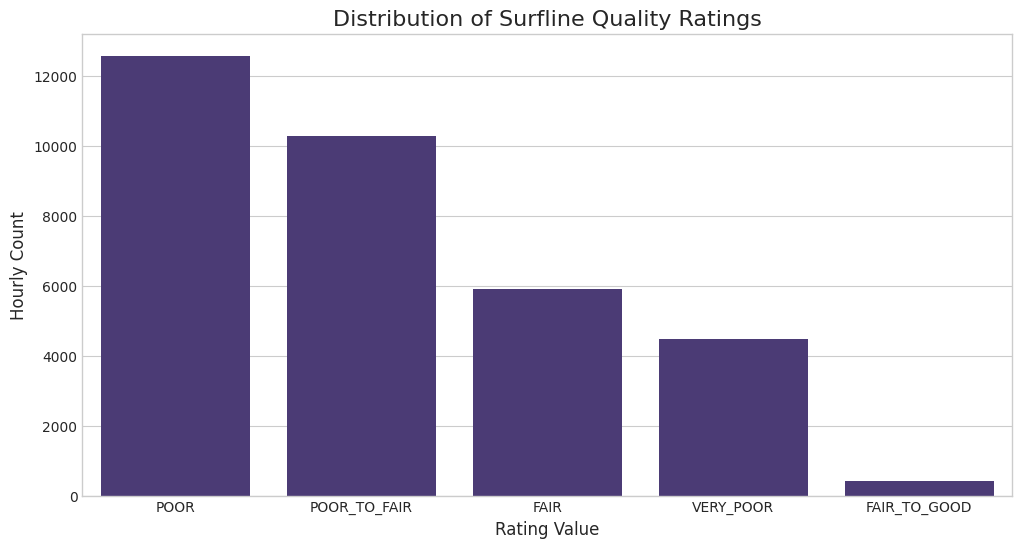

rating.value
0    0.132967
1    0.373567
2    0.305524
3    0.175497
4    0.012444
Name: proportion, dtype: float64

--- 3.1 Validating Features: Open-Meteo vs. Surfline Correlation ---


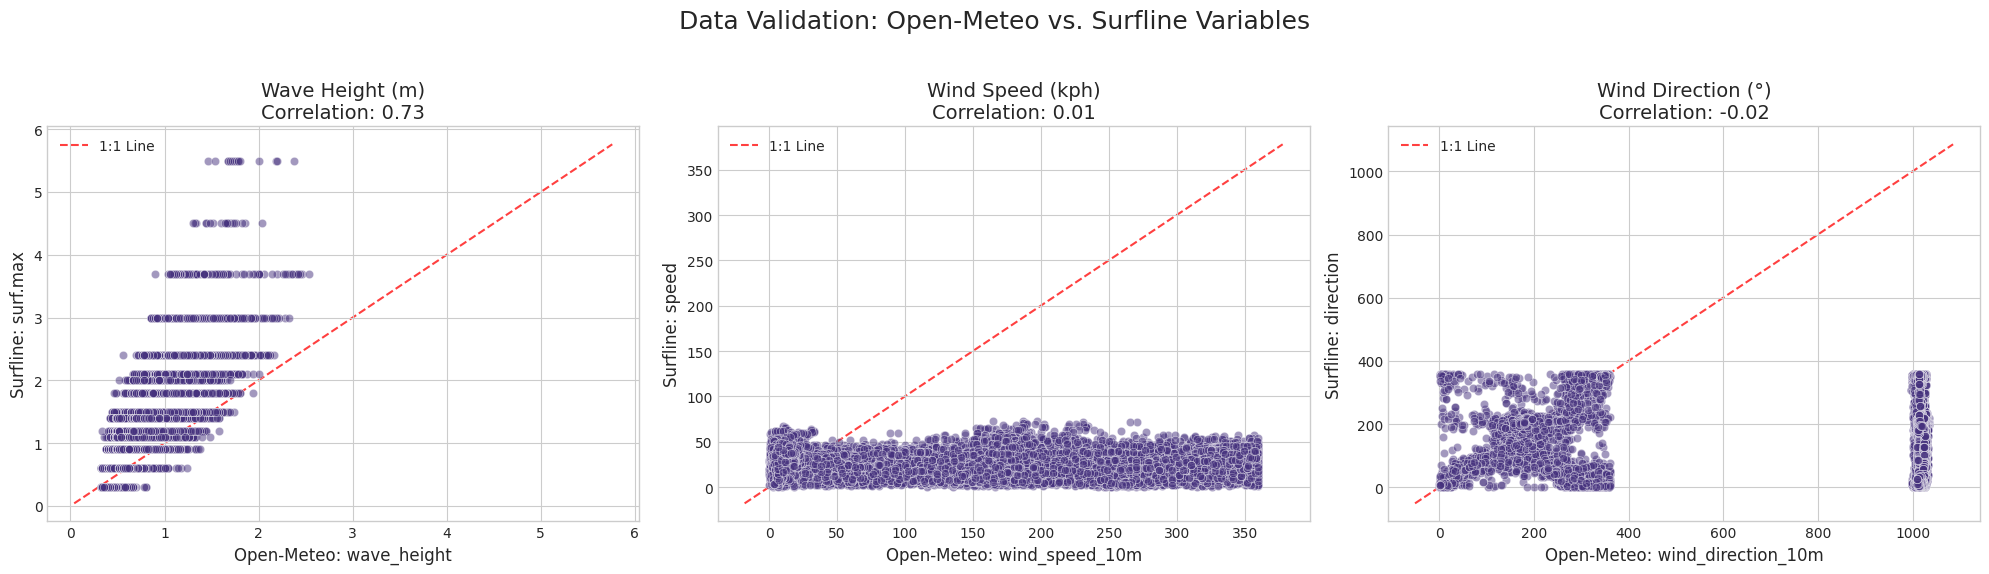


--- EDA Step 4.1 Complete ---


In [21]:
# -*- coding: utf-8 -*-

# =============================================================================
# SPRINT 1: EXPLORATORY ANALYSIS AND MODELING
# STEP 4.1: TARGET VARIABLE ANALYSIS & FEATURE VALIDATION
# =============================================================================

# --- 1. Library Imports for Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set a style for our plots for better aesthetics
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

print("--- Starting Step 4.1: EDA - Target Analysis and Feature Validation ---")

# --- 2. Analyze the Target Variable: 'rating.key' ---
print("\n--- 2.1 Analyzing the Target Variable: Surf Rating Distribution ---")

plt.figure(figsize=(12, 6))
sns.countplot(x='rating.key', data=df_final, order=df_final['rating.key'].value_counts().index)
plt.title('Distribution of Surfline Quality Ratings', fontsize=16)
plt.xlabel('Rating Value', fontsize=12)
plt.ylabel('Hourly Count', fontsize=12)
plt.show()

print(df_final['rating.value'].value_counts(normalize=True).sort_index())


# --- 3. Validate Features: Correlate Open-Meteo vs. Surfline ---
print("\n--- 3.1 Validating Features: Open-Meteo vs. Surfline Correlation ---")

# We need to identify the equivalent columns to compare
validation_pairs = {
    'Wave Height (m)': ('wave_height', 'surf.max'), # Open-Meteo vs. Surfline
    'Wind Speed (kph)': ('wind_speed_10m', 'speed'), # Open-Meteo vs. Surfline
    'Wind Direction (°)': ('wind_direction_10m', 'direction') # Open-Meteo vs. Surfline
}

# Create subplots to show all comparisons
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Data Validation: Open-Meteo vs. Surfline Variables', fontsize=18)

for i, (title, (om_col, sl_col)) in enumerate(validation_pairs.items()):
    ax = axes[i]
    
    # Create the scatter plot
    sns.scatterplot(data=df_final, x=om_col, y=sl_col, ax=ax, alpha=0.5)
    
    # Calculate Pearson correlation
    correlation = df_final[om_col].corr(df_final[sl_col])
    
    ax.set_title(f'{title}\nCorrelation: {correlation:.2f}', fontsize=14)
    ax.set_xlabel(f'Open-Meteo: {om_col}', fontsize=12)
    ax.set_ylabel(f'Surfline: {sl_col}', fontsize=12)
    
    # Add a 1:1 line for reference
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='1:1 Line')
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\n--- EDA Step 4.1 Complete ---")

--- Starting Step 4.3 (Corrected Script): Surgical Wind Data Fix ---

--- 2.1 Re-extracting ONLY wind_speed_10m and wind_direction_10m ---
Fetching wind data chunk 1/3...
Fetching wind data chunk 2/3...
Fetching wind data chunk 3/3...
✅ Successfully re-extracted wind data. Shape of fix DataFrame: (33720, 3)

--- 3.1 Performing surgical substitution ---
Dropped old wind columns: ['wind_speed_10m', 'wind_direction_10m', 'wind_speed_100m', 'wind_direction_100m']
Merged new, correct wind data into the final DataFrame.

--- 4.1 Validating the Fix: New Correlation Plot ---


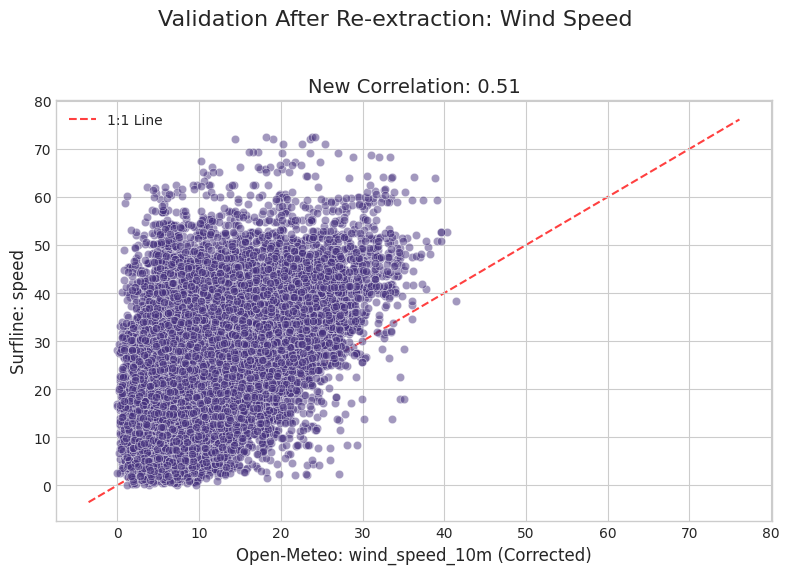


--- Surgical Fix and Validation Complete ---


In [23]:
# -*- coding: utf-8 -*-

# =============================================================================
# SPRINT 1: EXPLORATORY ANALYSIS AND MODELING
# STEP 4.3 (CORRECTED SCRIPT): SURGICAL RE-EXTRACTION AND SUBSTITUTION
# =============================================================================

# --- 1. Library Imports ---
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("--- Starting Step 4.3 (Corrected Script): Surgical Wind Data Fix ---")

# --- 2. Targeted Re-extraction of Wind Data Only ---
print("\n--- 2.1 Re-extracting ONLY wind_speed_10m and wind_direction_10m ---")
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# The URL has been corrected from .open-meteocom to .open-meteo.com
url = "https://archive-api.open-meteo.com/v1/archive" # <-- CORRECTED URL
base_params = {
    "latitude": -27.6, "longitude": -48.43,
    "hourly": ["wind_speed_10m", "wind_direction_10m"]
}

today_str = pd.to_datetime('today').strftime('%Y-%m-%d')
date_periods = [
    {"start_date": "2021-10-22", "end_date": "2022-12-31"},
    {"start_date": "2023-01-01", "end_date": "2024-12-31"},
    {"start_date": "2025-01-01", "end_date": today_str}
]

all_wind_dfs = []
for i, period in enumerate(date_periods):
    print(f"Fetching wind data chunk {i+1}/{len(date_periods)}...")
    current_params = base_params.copy()
    current_params["start_date"], current_params["end_date"] = period["start_date"], period["end_date"]
    
    responses = openmeteo.weather_api(url, params=current_params)
    response = responses[0]
    
    hourly = response.Hourly()
    hourly_data = {
        "wind_speed_10m": hourly.Variables(0).ValuesAsNumpy(),
        "wind_direction_10m": hourly.Variables(1).ValuesAsNumpy()
    }
    
    df_chunk = pd.DataFrame(data=hourly_data)
    df_chunk['datetime_utc'] = pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    )
    all_wind_dfs.append(df_chunk)
    time.sleep(2)

df_wind_fix = pd.concat(all_wind_dfs, ignore_index=True)
print(f"✅ Successfully re-extracted wind data. Shape of fix DataFrame: {df_wind_fix.shape}")

# --- 3. Surgical Substitution in the Main DataFrame ---
print("\n--- 3.1 Performing surgical substitution ---")
cols_to_drop = ['wind_speed_10m', 'wind_direction_10m', 'wind_speed_100m', 'wind_direction_100m']
existing_cols_to_drop = [col for col in cols_to_drop if col in df_final.columns]
df_final.drop(columns=existing_cols_to_drop, inplace=True)
print(f"Dropped old wind columns: {existing_cols_to_drop}")

df_final = pd.merge(df_final, df_wind_fix, on='datetime_utc', how='left')
print("Merged new, correct wind data into the final DataFrame.")

# --- 4. Final Validation ---
print("\n--- 4.1 Validating the Fix: New Correlation Plot ---")
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle('Validation After Re-extraction: Wind Speed', fontsize=16)

sns.scatterplot(data=df_final, x='wind_speed_10m', y='speed', ax=ax, alpha=0.5)
new_correlation = df_final['wind_speed_10m'].corr(df_final['speed'])
ax.set_title(f'New Correlation: {new_correlation:.2f}', fontsize=14)
ax.set_xlabel('Open-Meteo: wind_speed_10m (Corrected)', fontsize=12)
ax.set_ylabel('Surfline: speed', fontsize=12)

lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='1:1 Line')
ax.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\n--- Surgical Fix and Validation Complete ---")

In [25]:
df_final.columns

Index(['timestamp', 'utcOffset', 'rating.key', 'rating.value', 'utc_datetime',
       'datetime_utc', 'wave_height', 'wave_period', 'wave_direction',
       'wind_wave_height', 'wind_wave_direction', 'wind_wave_period',
       'swell_wave_height', 'swell_wave_direction', 'swell_wave_period',
       'ocean_current_velocity', 'ocean_current_direction', 'temperature_2m',
       'relative_humidity_2m', 'rain', 'pressure_msl', 'surface_pressure',
       'apparent_temperature', 'soil_temperature_0_to_7cm', 'is_day',
       'sunshine_duration', 'surf.min', 'surf.max', 'surf.plus',
       'surf.humanRelation', 'surf.raw.min', 'surf.raw.max',
       'swell_1_direction', 'swell_2_direction', 'swell_1_height',
       'swell_2_height', 'swell_1_period', 'swell_2_period', 'swell_1_power',
       'swell_2_power', 'type', 'height', 'speed', 'direction',
       'directionType', 'gust', 'optimalScore', 'wind_speed_10m',
       'wind_direction_10m'],
      dtype='object')

In [26]:
# -*- coding: utf-8 -*-

# =============================================================================
# SPRINT 1: EXPLORATORY ANALYSIS AND MODELING
# STEP 4.4 (CORRECTED): FINAL FEATURE SELECTION WITH NO LEAKAGE
# =============================================================================

print("--- Starting Step 4.4 (Corrected): Final Feature Selection ---")

# --- 1. Drop Unnecessary and Leaky Columns ---
# We now add the Surfline features to this list to prevent data leakage.
cols_to_drop = [
    # --- Surfline features to prevent data leakage ---
    'sl_surf_min', 'sl_surf_max', 'sl_wind_speed', 'sl_wind_gust', 'sl_wind_optimal_score',
    'swell_1_direction', 'swell_1_height', 'swell_1_period', 'swell_1_power',
    'swell_2_direction', 'swell_2_height', 'swell_2_period', 'swell_2_power',
    
    # --- Metadata and redundant columns (as before) ---
    'datetime_utc', # We will set this as the index instead
    'rating.key', 'utc_datetime', 'surf.humanRelation',
    'surf.raw.min', 'surf.raw.max', 'type', 'directionType', 'is_day', 'sunshine_duration',
    'soil_temperature_0_to_7cm', 'wind_speed_100m', 'wind_direction_100m'
]

# Rename columns first to make the list cleaner
rename_map = {
    'rating.value': 'rating',
    'wave_height': 'om_wave_height',
    'wave_period': 'om_wave_period',
    'wave_direction': 'om_wave_direction',
    'wind_wave_height': 'om_wind_wave_height',
    'wind_wave_direction': 'om_wind_wave_direction',
    'wind_wave_period': 'om_wind_wave_period',
    'swell_wave_height': 'om_swell_wave_height',
    'swell_wave_direction': 'om_swell_wave_direction',
    'swell_wave_period': 'om_swell_wave_period',
    'wind_speed_10m': 'om_wind_speed',
    'wind_direction_10m': 'om_wind_direction',
    'surf.min': 'sl_surf_min',
    'surf.max': 'sl_surf_max',
    'speed': 'sl_wind_speed',
    'gust': 'sl_wind_gust',
    'optimalScore': 'sl_wind_optimal_score'
}
# Use the corrected df_final with the fixed wind data
df_prepared = df_final.rename(columns=rename_map)

# Ensure all columns to drop actually exist in the DataFrame
existing_cols_to_drop = [col for col in cols_to_drop if col in df_prepared.columns]
df_prepared = df_prepared.drop(columns=existing_cols_to_drop)

print(f"Dropped {len(existing_cols_to_drop)} unnecessary/leaky columns.")


# --- 2. Handle Remaining Null Values ---
print(f"\nNull values before handling:\n{df_prepared.isnull().sum()[df_prepared.isnull().sum() > 0]}")
for col in df_prepared.columns:
    if df_prepared[col].isnull().any():
        median_val = df_prepared[col].median()
        df_prepared[col].fillna(median_val, inplace=True)
        print(f"Filled nulls in '{col}' with median value ({median_val:.2f}).")

# --- 3. Final Inspection of the Model-Ready DataFrame ---
df_model_ready = df_prepared.copy()

print("\n" + "="*50)
print("LEAK-FREE, MODEL-READY DATAFRAME INSPECTION")
print("="*50)
print(f"Final Shape: {df_model_ready.shape}")
print("All columns are numeric, non-null, and free of data leakage.")
df_model_ready.info(verbose=True)

print("\n--- `df_model_ready` is now complete. ---")

--- Starting Step 4.4 (Corrected): Final Feature Selection ---
Dropped 24 unnecessary/leaky columns.

Null values before handling:
om_wave_period               24
om_wind_wave_period          24
om_swell_wave_period         24
ocean_current_velocity     1797
ocean_current_direction    1797
dtype: int64
Filled nulls in 'om_wave_period' with median value (7.05).
Filled nulls in 'om_wind_wave_period' with median value (1.40).
Filled nulls in 'om_swell_wave_period' with median value (6.15).
Filled nulls in 'ocean_current_velocity' with median value (0.50).
Filled nulls in 'ocean_current_direction' with median value (153.00).

LEAK-FREE, MODEL-READY DATAFRAME INSPECTION
Final Shape: (33670, 25)
All columns are numeric, non-null, and free of data leakage.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33670 entries, 0 to 33669
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp         

/tmp/ipykernel_71109/2409994102.py:60: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_prepared[col].fillna(median_val, inplace=True)
/tmp/ipykernel_71109/2409994102.py:60: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

In [29]:
df_final['rating.key'].value_counts()

rating.key
POOR            12578
POOR_TO_FAIR    10287
FAIR             5909
VERY_POOR        4477
FAIR_TO_GOOD      419
Name: count, dtype: int64

In [33]:
df_model_ready.columns

Index(['timestamp', 'utcOffset', 'rating', 'om_wave_height', 'om_wave_period',
       'om_wave_direction', 'om_wind_wave_height', 'om_wind_wave_direction',
       'om_wind_wave_period', 'om_swell_wave_height',
       'om_swell_wave_direction', 'om_swell_wave_period',
       'ocean_current_velocity', 'ocean_current_direction', 'temperature_2m',
       'relative_humidity_2m', 'rain', 'pressure_msl', 'surface_pressure',
       'apparent_temperature', 'surf.plus', 'height', 'direction',
       'om_wind_speed', 'om_wind_direction'],
      dtype='object')

In [28]:
df_model_ready['rating'].value_counts()

rating
1    12578
2    10287
3     5909
0     4477
4      419
Name: count, dtype: int64

In [34]:
# -*- coding: utf-8 -*-

# =============================================================================
# SPRINT 1: EXPLORATORY ANALYSIS AND MODELING
# STEP 4.5: THE DEFINITIVE MODEL-READY DATAFRAME
# =============================================================================

print("--- Starting Step 4.5: Creating the Definitive Model-Ready DataFrame ---")

# --- 1. Reload the Cleaned `df_final` ---
# This ensures we are starting from our complete, corrected dataset.
# (Assuming df_final from the surgical wind fix is in memory)

# --- 2. Add Tides Data ---
# We missed this in the last step, so we'll merge it in now.
df_tides = pd.read_csv('landing_zone/landing_zone_surfline_tides.csv', sep=';', decimal='.')
df_tides['datetime_utc'] = pd.to_datetime(df_tides['datetime_utc'], utc=True)
# Select only the height and timestamp for the merge
df_tides_to_merge = df_tides[['datetime_utc', 'height']].rename(columns={'height': 'tide_height'})

# Use a left merge to add tide height to our main DataFrame
df_with_tides = pd.merge(df_final, df_tides_to_merge, on='datetime_utc', how='left')
print(f"Added tides data. Shape is now: {df_with_tides.shape}")


# --- 3. Time-Based Feature Engineering ---
print("\n--- Engineering time-based features from the timestamp ---")
# Ensure the timestamp is treated as a datetime object
df_with_tides['datetime_utc'] = pd.to_datetime(df_with_tides['timestamp'], unit='s', utc=True)

# Extract cyclical features
df_with_tides['hour_of_day'] = df_with_tides['datetime_utc'].dt.hour
df_with_tides['day_of_week'] = df_with_tides['datetime_utc'].dt.dayofweek # Monday=0, Sunday=6
df_with_tides['month_of_year'] = df_with_tides['datetime_utc'].dt.month
print("Created 'hour_of_day', 'day_of_week', and 'month_of_year' features.")


# --- 4. Final Column Selection and Cleaning (No Leakage) ---
print("\n--- Performing final column selection and cleaning ---")
df_prepared = df_with_tides.copy()

# Rename columns for clarity
rename_map = {
    'rating.value': 'rating',
    'wave_height': 'om_wave_height', 'wave_period': 'om_wave_period', 'wave_direction': 'om_wave_direction',
    'wind_wave_height': 'om_wind_wave_height', 'wind_wave_direction': 'om_wind_wave_direction', 'wind_wave_period': 'om_wind_wave_period',
    'swell_wave_height': 'om_swell_wave_height', 'swell_wave_direction': 'om_swell_wave_direction', 'swell_wave_period': 'om_swell_wave_period',
    'wind_speed_10m': 'om_wind_speed', 'wind_direction_10m': 'om_wind_direction'
}
df_prepared.rename(columns=rename_map, inplace=True)

# Define ALL columns we don't want in the final model
# This includes metadata, leaky Surfline features, and now-redundant time columns
cols_to_drop = [
    'timestamp', 'datetime_utc', 'utcOffset', 'rating.key', 'utc_datetime',
    'surf.min', 'surf.max', 'surf.plus', 'surf.humanRelation', 'surf.raw.min', 'surf.raw.max',
    'swell_1_direction', 'swell_2_direction', 'swell_1_height', 'swell_2_height',
    'swell_1_period', 'swell_2_period', 'swell_1_power', 'swell_2_power',
    'type', 'height', 'speed', 'direction', 'directionType', 'gust', 'optimalScore',
    'wind_speed_100m', 'wind_direction_100m', 'is_day', 'sunshine_duration', 'soil_temperature_0_to_7cm'
]
existing_cols_to_drop = [col for col in cols_to_drop if col in df_prepared.columns]
df_model_ready = df_prepared.drop(columns=existing_cols_to_drop)

# --- 5. Handle Final Nulls (especially for tides) ---
print(f"\nNull values before handling:\n{df_model_ready.isnull().sum()[df_model_ready.isnull().sum() > 0]}")
for col in df_model_ready.columns:
    if df_model_ready[col].isnull().any():
        median_val = df_model_ready[col].median()
        df_model_ready[col].fillna(median_val, inplace=True)
        print(f"Filled nulls in '{col}' with median value ({median_val:.2f}).")

# --- 6. Final Inspection ---
print("\n" + "="*50)
print("DEFINITIVE MODEL-READY DATAFRAME INSPECTION")
print("="*50)
print(f"Final Shape: {df_model_ready.shape}")
df_model_ready.info(verbose=True)

print("\n--- `df_model_ready` is now complete and ready for modeling. ---")

--- Starting Step 4.5: Creating the Definitive Model-Ready DataFrame ---
Added tides data. Shape is now: (33670, 50)

--- Engineering time-based features from the timestamp ---
Created 'hour_of_day', 'day_of_week', and 'month_of_year' features.

--- Performing final column selection and cleaning ---

Null values before handling:
om_wave_period               24
om_wind_wave_period          24
om_swell_wave_period         24
ocean_current_velocity     1797
ocean_current_direction    1797
dtype: int64
Filled nulls in 'om_wave_period' with median value (7.05).
Filled nulls in 'om_wind_wave_period' with median value (1.40).
Filled nulls in 'om_swell_wave_period' with median value (6.15).
Filled nulls in 'ocean_current_velocity' with median value (0.50).
Filled nulls in 'ocean_current_direction' with median value (153.00).

DEFINITIVE MODEL-READY DATAFRAME INSPECTION
Final Shape: (33670, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33670 entries, 0 to 33669
Data columns (total 24 co

/tmp/ipykernel_71109/4238174830.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model_ready[col].fillna(median_val, inplace=True)
/tmp/ipykernel_71109/4238174830.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

In [36]:
df_model_ready.columns

Index(['rating', 'om_wave_height', 'om_wave_period', 'om_wave_direction',
       'om_wind_wave_height', 'om_wind_wave_direction', 'om_wind_wave_period',
       'om_swell_wave_height', 'om_swell_wave_direction',
       'om_swell_wave_period', 'ocean_current_velocity',
       'ocean_current_direction', 'temperature_2m', 'relative_humidity_2m',
       'rain', 'pressure_msl', 'surface_pressure', 'apparent_temperature',
       'om_wind_speed', 'om_wind_direction', 'tide_height', 'hour_of_day',
       'day_of_week', 'month_of_year'],
      dtype='object')

--- Starting Step 5: Machine Learning Modeling and Feature Importance ---
Features (X) shape: (33670, 23)
Target (y) shape: (33670,)
Training set size: 26936
Testing set size: 6734

--- Training the XGBoost Classifier ---


/home/marcos/projects/openmeteo/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:08:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model training complete.

--- Evaluating Model Performance on the Test Set ---
Model Accuracy: 0.6910

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.72      0.78       895
           1       0.72      0.77      0.74      2516
           2       0.62      0.65      0.63      2057
           3       0.66      0.61      0.63      1182
           4       0.76      0.30      0.43        84

    accuracy                           0.69      6734
   macro avg       0.72      0.61      0.64      6734
weighted avg       0.69      0.69      0.69      6734


Confusion Matrix:


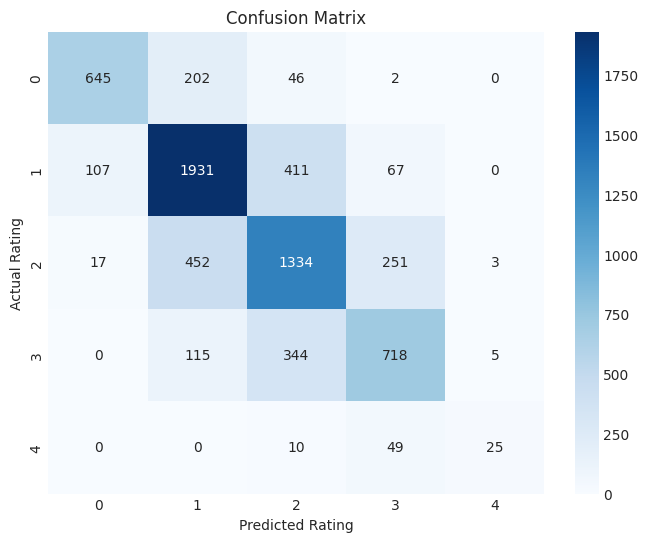


--- Analyzing Feature Importance ---


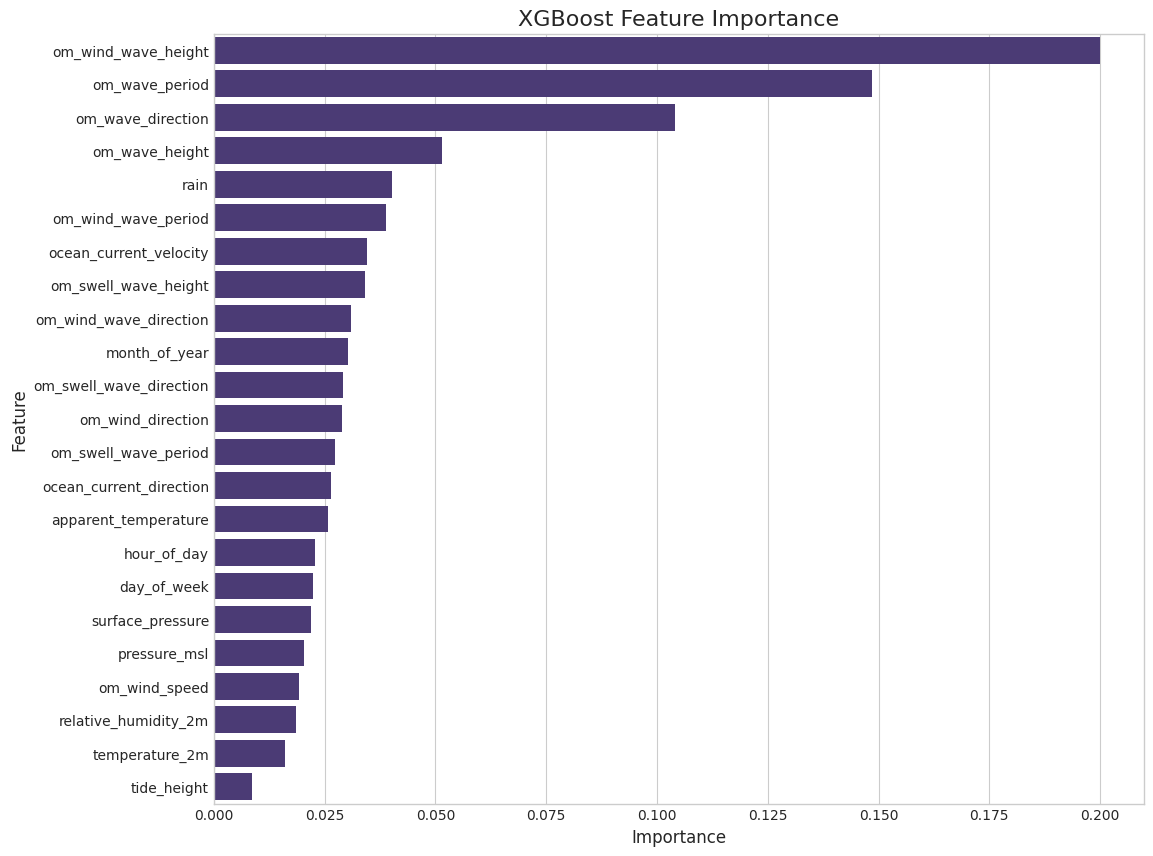


Top 10 Most Important Features:
                   feature  importance
3      om_wind_wave_height    0.199906
1           om_wave_period    0.148484
2        om_wave_direction    0.104072
0           om_wave_height    0.051461
13                    rain    0.040150
5      om_wind_wave_period    0.038834
9   ocean_current_velocity    0.034533
6     om_swell_wave_height    0.034019
4   om_wind_wave_direction    0.031019
22           month_of_year    0.030190

--- Sprint 1 Modeling and Analysis Complete ---


In [39]:
# -*- coding: utf-8 -*-

# =============================================================================
# SPRINT 1: EXPLORATORY ANALYSIS AND MODELING
# STEP 5: ML MODELING AND FEATURE IMPORTANCE
# =============================================================================

# --- 1. Library Imports ---
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("--- Starting Step 5: Machine Learning Modeling and Feature Importance ---")

# --- 2. Prepare Data for Modeling ---
# Separate features (X) and target (y)
X = df_model_ready.drop('rating', axis=1)
y = df_model_ready['rating']

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

# Split data into training and testing sets
# We use a 80/20 split. random_state ensures reproducibility.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y # Stratify ensures similar class distribution in train/test
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")


# --- 3. Train the XGBoost Model ---
print("\n--- Training the XGBoost Classifier ---")
# Initialize the XGBoost classifier for multi-class classification
# We use some standard starting parameters
xgb_classifier = xgb.XGBClassifier(
    objective='multi:softmax', # Specifies multi-class classification
    num_class=len(y.unique()),  # Number of unique rating values
    n_estimators=100,           # Number of trees to build
    learning_rate=0.1,
    max_depth=5,
    use_label_encoder=False,    # Suppress a deprecation warning
    eval_metric='mlogloss'
)

# Train the model on the training data
xgb_classifier.fit(X_train, y_train)
print("Model training complete.")


# --- 4. Evaluate Model Performance ---
print("\n--- Evaluating Model Performance on the Test Set ---")
y_pred = xgb_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# Print a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display a confusion matrix to see class-by-class performance
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title('Confusion Matrix')
plt.ylabel('Actual Rating')
plt.xlabel('Predicted Rating')
plt.show()


# --- 5. Analyze Feature Importance ---
print("\n--- Analyzing Feature Importance ---")
# This is the core goal of our Sprint 1 modeling effort

# Create a DataFrame for feature importances for easy plotting
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_classifier.feature_importances_
}).sort_values('importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=importances)
plt.title('XGBoost Feature Importance', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

print("\nTop 10 Most Important Features:")
print(importances.head(10))

print("\n--- Sprint 1 Modeling and Analysis Complete ---")

In [40]:
# =============================================================================
# SPRINT 1: FINAL DELIVERABLE
# STEP 6: SAVE THE TRAINED MODEL
# =============================================================================
import joblib

# Save the trained model to a file
model_filename = 'modelo_xgboost.pkl'
joblib.dump(xgb_classifier, model_filename)

print(f"Model successfully saved to: {model_filename}")

Model successfully saved to: modelo_xgboost.pkl
